# Trabajo Práctico 1

## Variable de Estudio: Consumo Interno per capita KG por Habitante

#### Asignatura: Análisis de Series Temporales
#### Docente:    Rodrigo Del Rosso
#### Asistentes: Sebastian Calcagno - Fernando Martinez

#### Integrantes:
* Del Villar, Javier Alonso
* Otrino, Facundo Damián
* Pistoya, Haydeé Soledad
* Rojas, Mariano Arturo
* Sorza, Edwin Andrés
* Vaillard, Leandro Carlos



In [1]:
library(astsa)
library(dygraphs)
library(forecast)
library(fpp)
library(ggplot2)
library(gridExtra)
library(MLmetrics)
library(PerformanceAnalytics)
library(Quandl)
library(quantmod)
library(rlang)
library(tseries)
library(urca)
library(readr)
library(nortest)
library(lessR)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas


Loading required package: fma


Attaching package: ‘fma’


The following objects are masked from ‘package:astsa’:

    chicken, sales


Loading required package: expsmooth

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: tseries


Attaching package: ‘fpp’


The following object is masked from ‘package:astsa’:

    oil



Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall


Loading required package: xts


Attaching package: ‘PerformanceAnalytics’


The following object is masked from ‘package:graphics’:

    legend


Loading required package: TTR


lessR 3.9.9  feedback: gerbing@pdx.edu  web: le

In [2]:
# Función para construir una matriz con los valores de AIC
AIC_Matrix <- function(ts, p.order, q.order) {
  # require(forecast)
  aic_matrix <- matrix(data = NA, nrow = p.order, ncol = q.order)
  max_i <- p.order - 1
  max_j <- q.order - 1
  for (i in 0:max_i) {
    for (j in 0:max_j) {
      aic <- arima(ts, order = c(i, 0, j))$aic
      a <- i + 1
      b <- j + 1
      aic_matrix[a, b] <- aic
    }
  }
  rownames(aic_matrix) <- c(0:max_i)
  colnames(aic_matrix) <- c(0:max_j)
  return(aic_matrix)
}

# Función para testear normalidad
Normality_Test <- function(ts, type = c("JB", "AD", "SW")) {
  # require(tseries)
  # require(nortest)
  if (type == "JB") {
    p_val <- jarque.bera.test(ts)$p.value
    stat <- jarque.bera.test(ts)$statistic
  } else if (type == "AD") {
    p_val <- ad.test(ts)$p.value
    stat <- ad.test(ts)$statistic
  } else {
    p_val <- shapiro.test(ts)$p.value
    stat <- shapiro.test(ts)$statistic
  }
  table <- data.frame(
    P_Value = p_val,
    Statistic = stat
  )
  return(table)
}

# Función de Incorrelación
Incorrelation <- function(ts, type = c("Ljung-Box", "Box-Pierce"), fitdf = 0) {
  p_ljung_box <- NULL
  s_ljung_box <- NULL
  for (i in 0:(length(ts) / 4)) {
    p_ljung_box[i] <- Box.test(ts, lag = i, type = type, fitdf = fitdf)$p.value
    s_ljung_box[i] <- Box.test(ts, lag = i, type = type, fitdf = fitdf)$statistic
  }
  table <- data.frame(
    j = 1:(length(ts) / 4),
    P_Value = p_ljung_box,
    Statistic = s_ljung_box
  )
  return(table)
}

# Alternativa de función de Incorrelación
Incorrelation2 <- function(ts, type = c("Ljung-Box", "Box-Pierce"), fitdf = 0) {
  if (is.ts(ts)) {
    p_ljung_box <- NULL
    s_ljung_box <- NULL
    for (i in 0:(length(ts) / 4)) {
      p_ljung_box[i] <- Box.test(ts, lag = i, type = type, fitdf = fitdf)$p.value
      s_ljung_box[i] <- Box.test(ts, lag = i, type = type, fitdf = fitdf)$statistic
    }
    table <- data.frame(
      id = 1:(length(ts) / 4),
      P_Value = p_ljung_box,
      Statistic = s_ljung_box
    )
    return(table)
  } else {
    print("El objeto no es una serie de tiempo")
  }
}

# Función para testear Estacionalidad
is_stationary <- function(adf_test, p_Valor = 0.05) {
  if (adf_test$p.value >= p_Valor) {
    print("No rechazo la hipótesis nula, la serie no es estacionaria")
  } else {
    print("Rechazo la hipótesis nula, la serie es estacionaria")
  }
}

In [3]:
# Lectura de Datos y creación de varaibles

imported <- read_csv("data/serie-tiempo-indicadores-mensuales-bovinos.csv",
                     col_types = cols(indice_tiempo = col_date(format = "%Y-%m")))


serie <- ts(imported$consumo_interno_per_capita_kg_por_habitante, frequency = 12, start = c(1998, 01))

log_serie <- log10(serie)

diff_log_serie <- diff(log_serie)

diff12_log_serie <- diff(log_serie, 12)
diff12_log_serie <- diff(log_serie, 12)

diff12_1_log_serie <- diff(diff12_log_serie)

# Data Overview

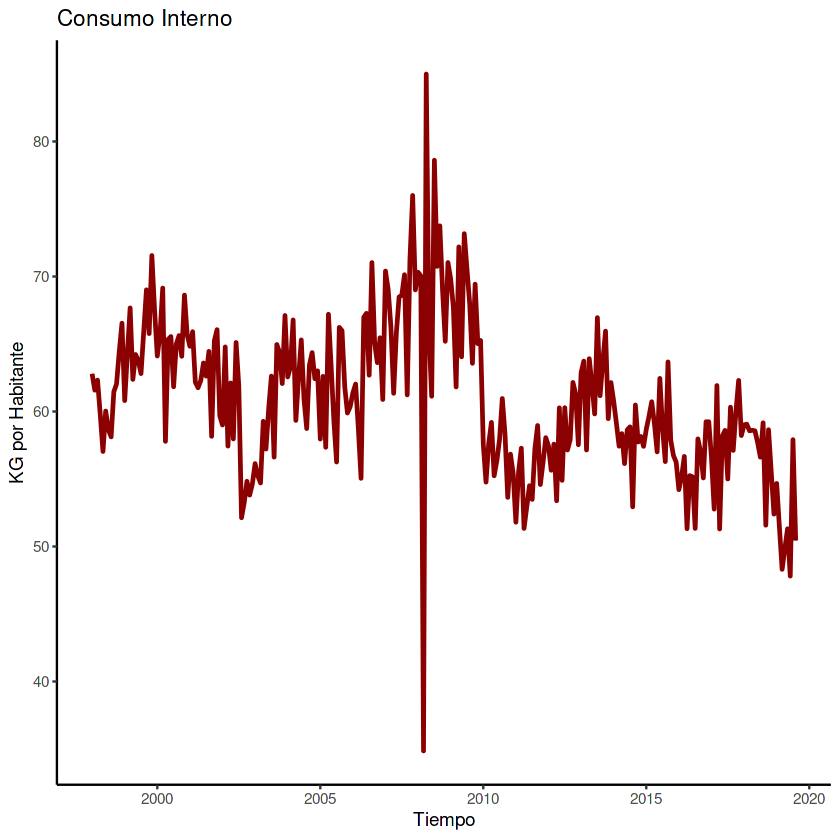

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34.86   57.27   60.34   60.84   64.45   84.99 

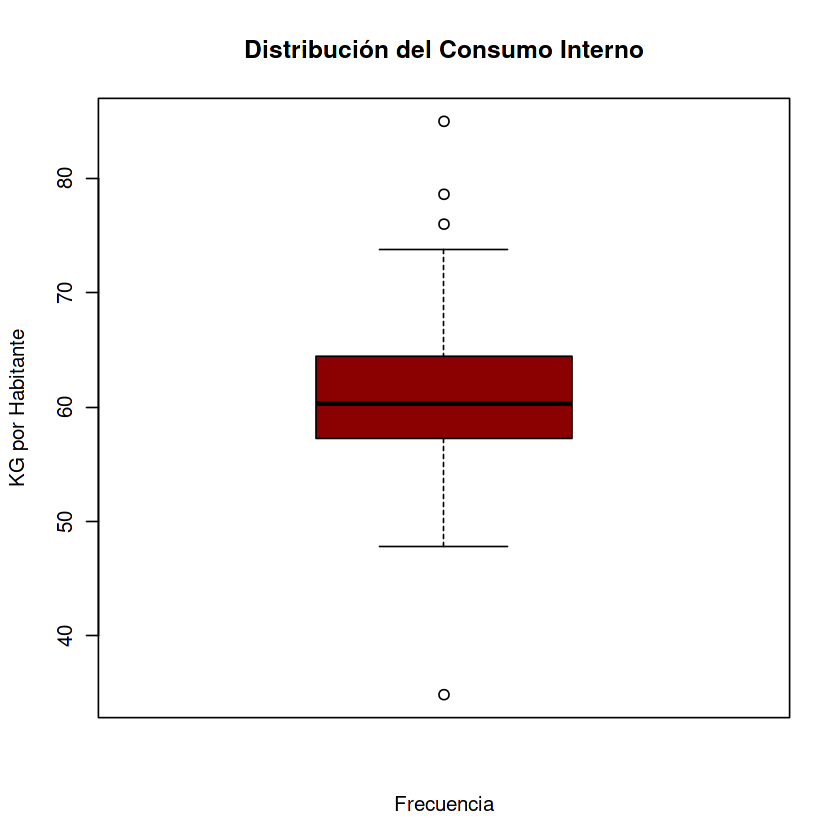

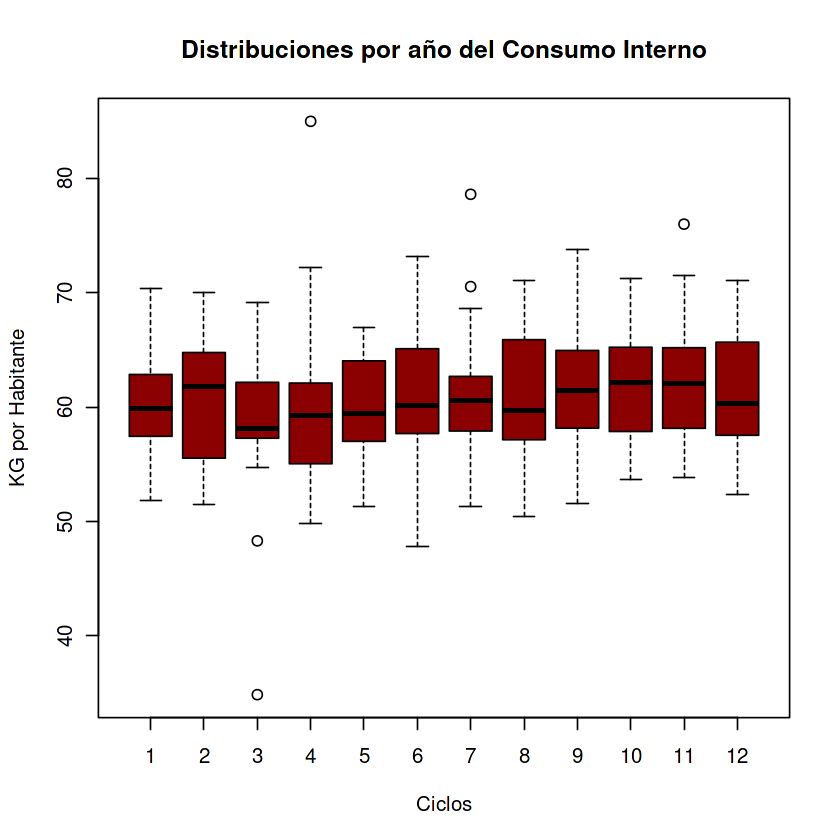

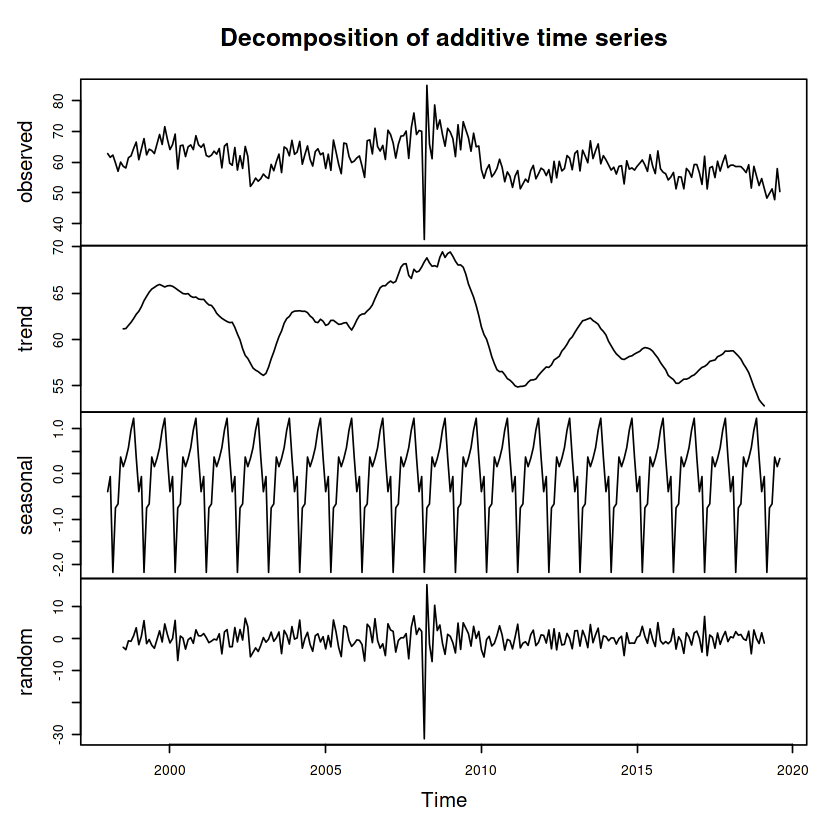

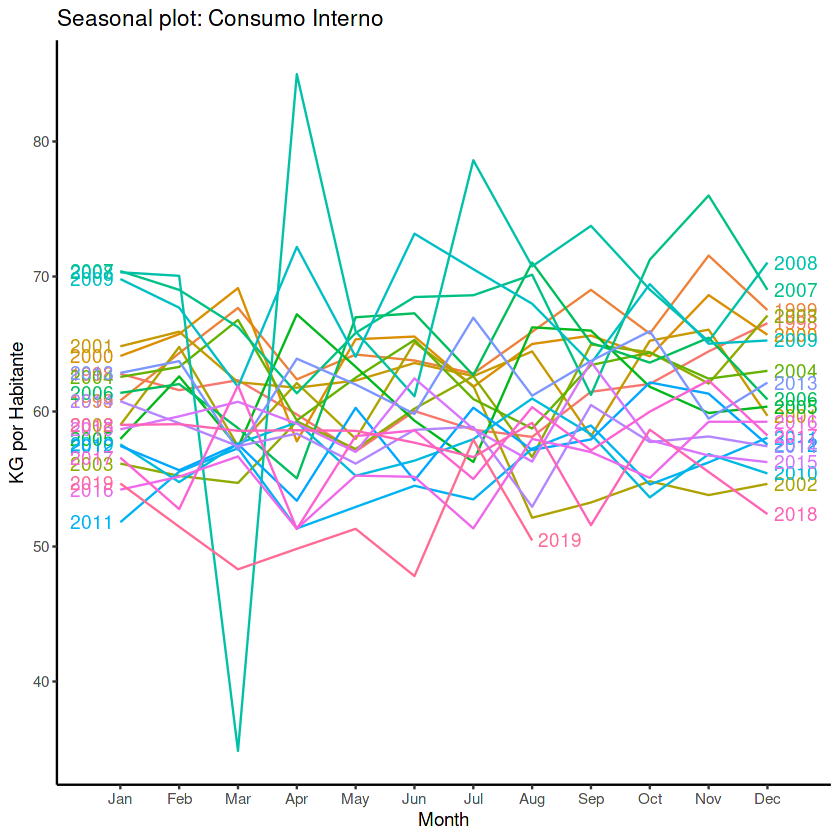

In [4]:
autoplot(
  serie,
  main = "Consumo Interno",
  xlab = "Tiempo",
  ylab = "KG por Habitante"
) + geom_line(size = 1, color = "darkred") +  theme_classic()

boxplot(
  serie,
  main = "Distribución del Consumo Interno",
  xlab = "Frecuencia",
  ylab = "KG por Habitante",
  col = "darkred"
)

 summary(serie)

# Boxplot de la serie según el año
boxplot(
  serie ~ cycle(serie),
  main = "Distribuciones por año del Consumo Interno",
  xlab = "Ciclos",
  ylab = "KG por Habitante",
  col = "darkred"
)

# Descomposición de la Serie
plot(decompose(serie))

ggseasonplot(serie, year.labels=TRUE, year.labels.left=TRUE) +
  ylab("KG por Habitante") +
  ggtitle("Seasonal plot: Consumo Interno") +  theme_classic()

# Gráficos de la serie y sus transformaciones

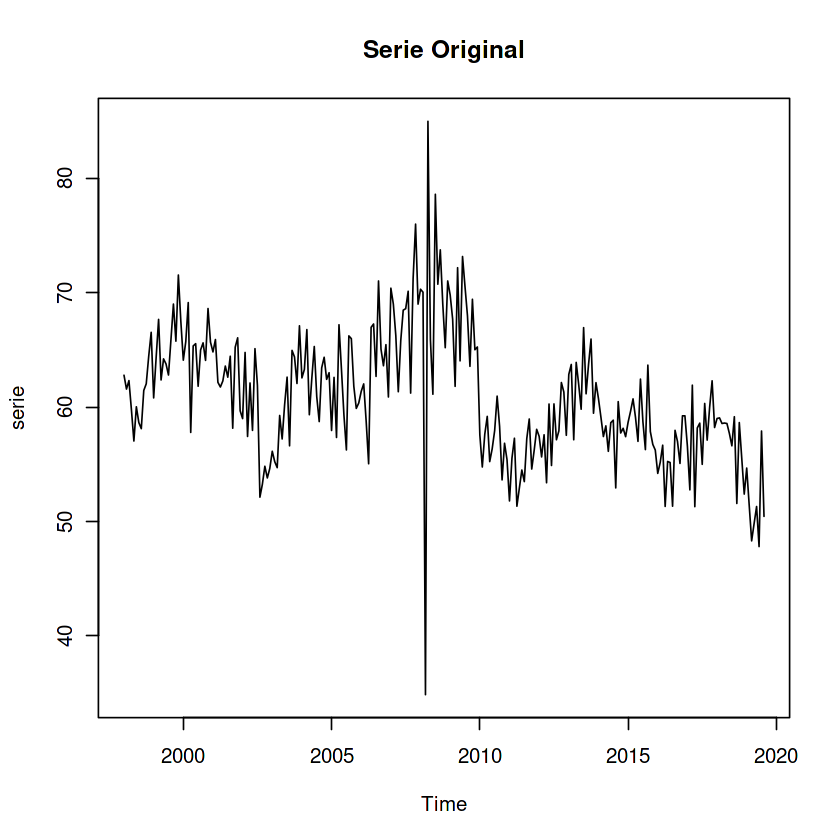

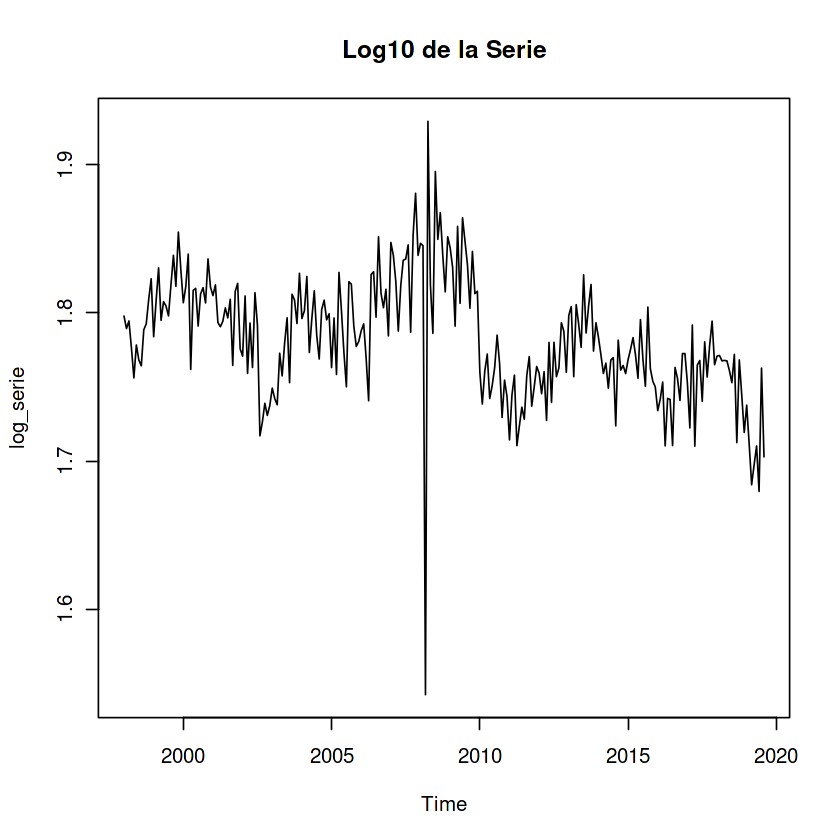

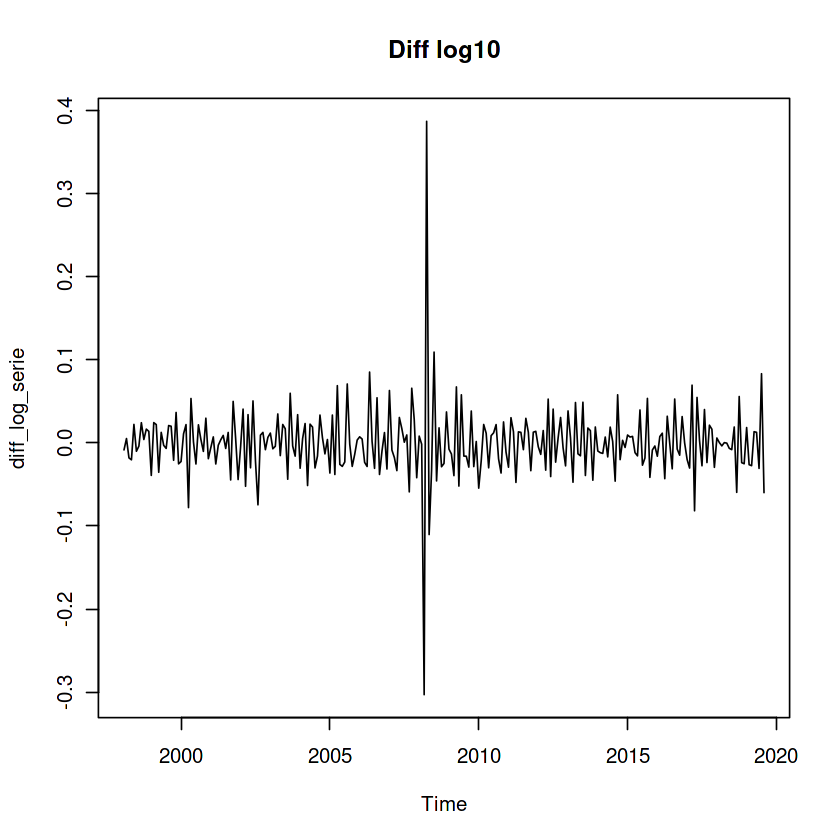

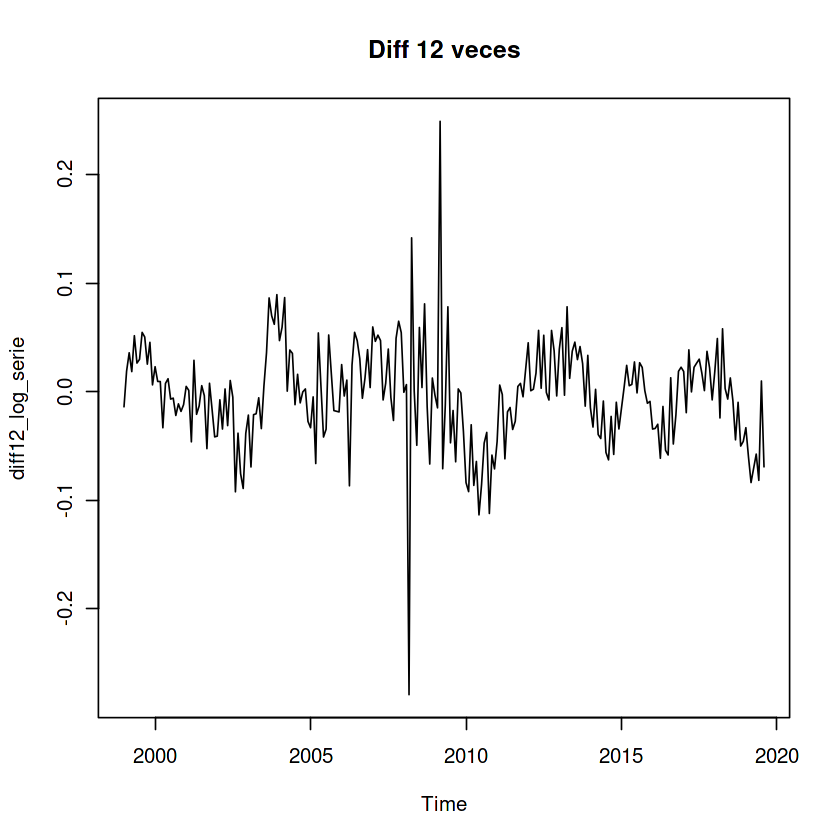

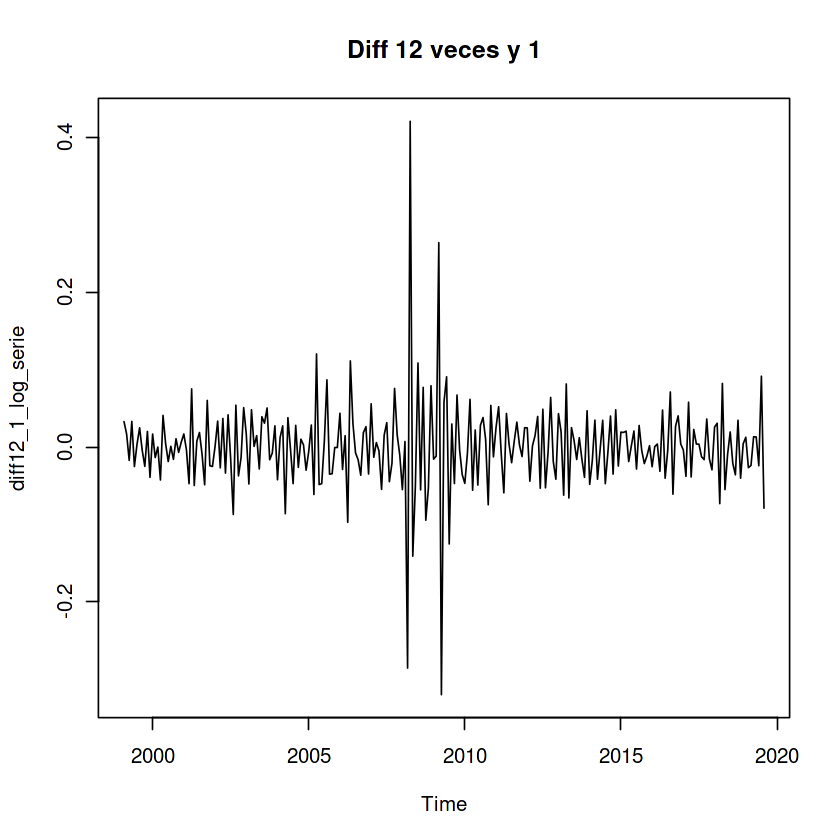

In [5]:
plot(serie, main = "Serie Original")

plot(log_serie, main = "Log10 de la Serie")

plot(diff_log_serie, main = "Diff log10") # Diferencia de 1 mes atras  en log para remove estacionariedad (stationary)

plot(diff12_log_serie, main = "Diff 12 veces") # Diferencia de 12 meses atras  en log seasonal

plot(diff12_1_log_serie, main = "Diff 12 veces y 1") # se ataca el stacionary y el seasonal 

# Gráficos de la ACF y Partial ACF

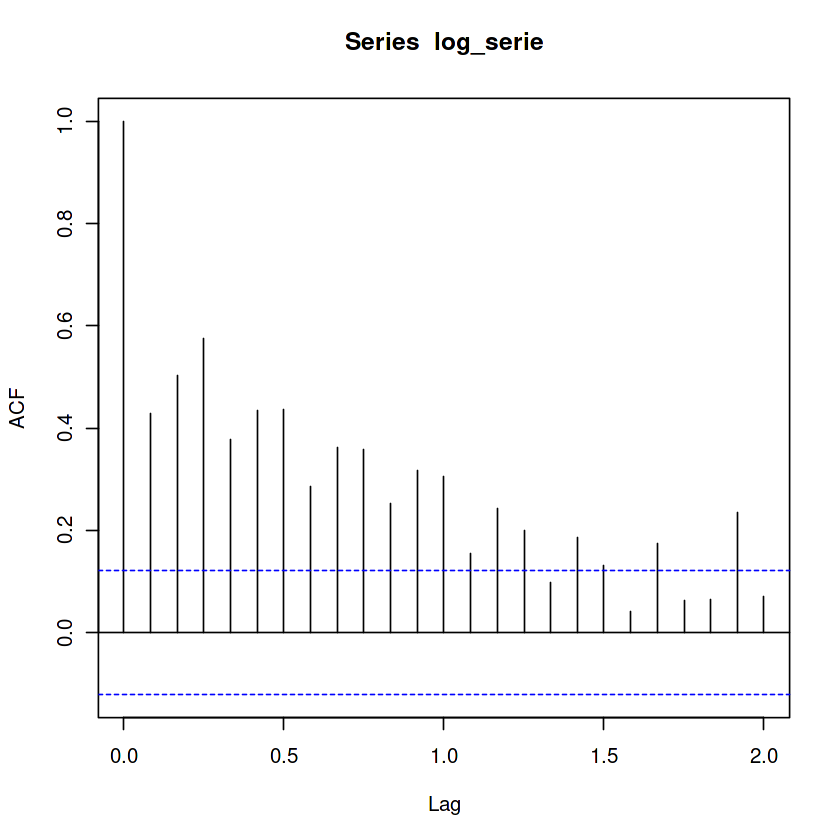

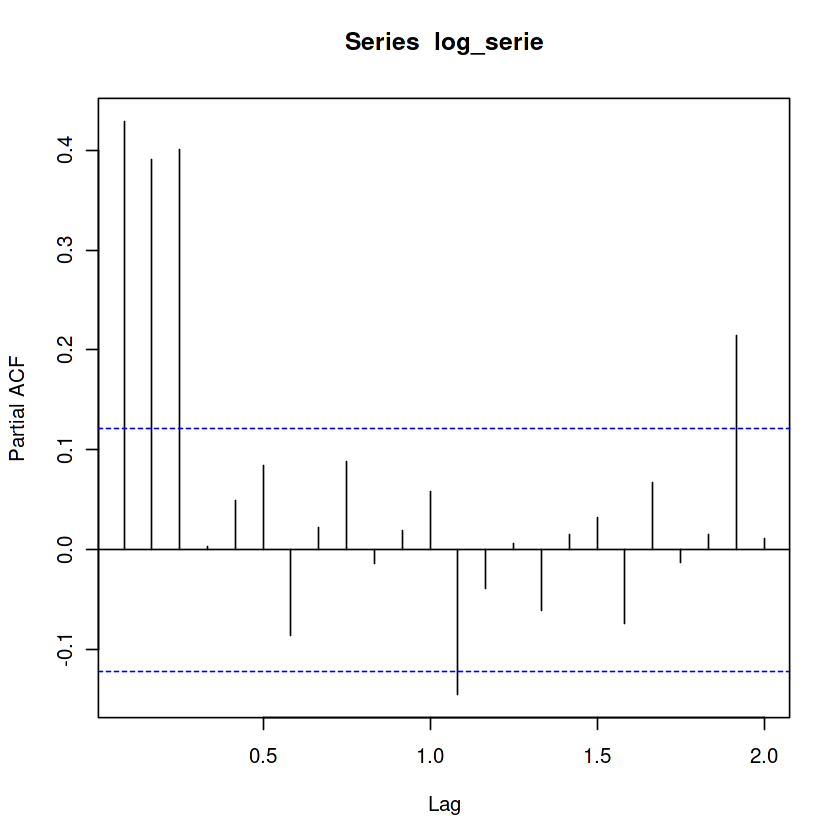

In [6]:
acf(log_serie)
pacf(log_serie)

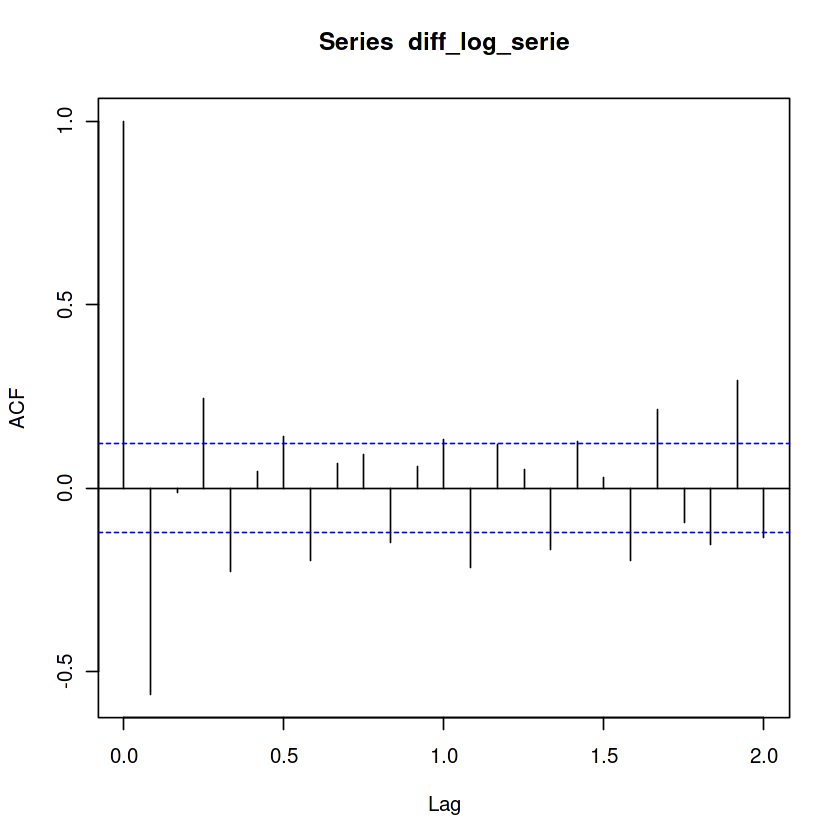

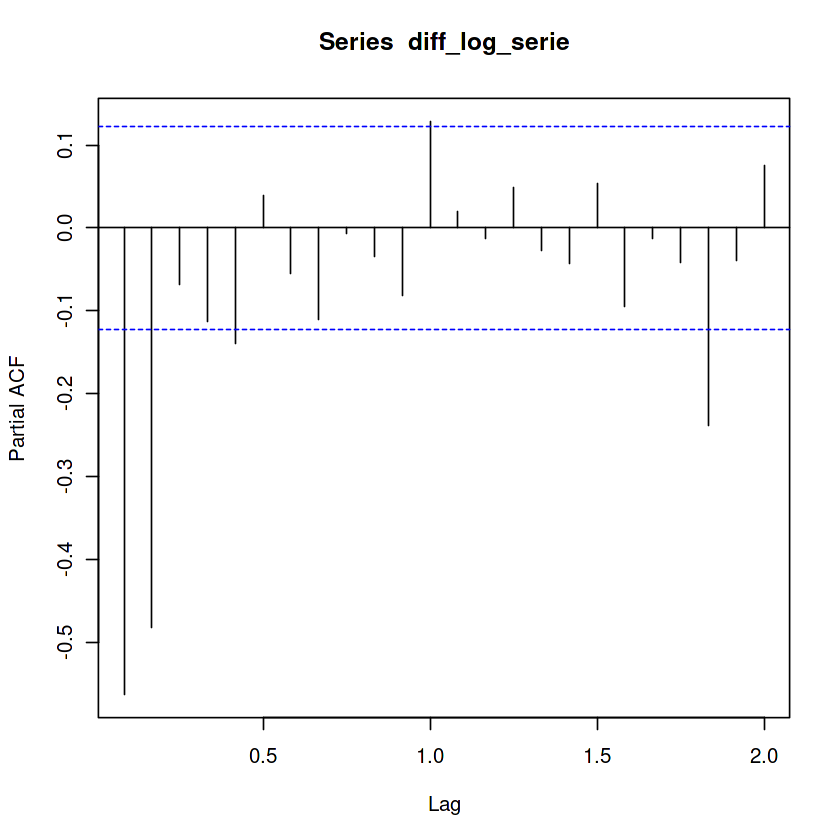

In [7]:
acf(diff_log_serie)
pacf(diff_log_serie)

# Leandro Vaillard: es un AR1

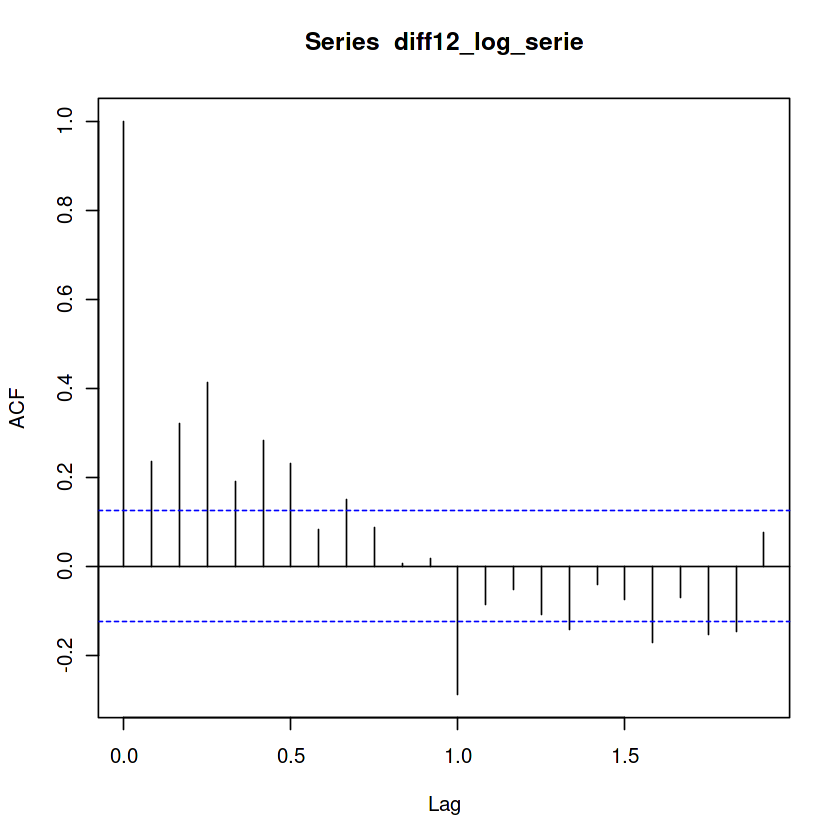

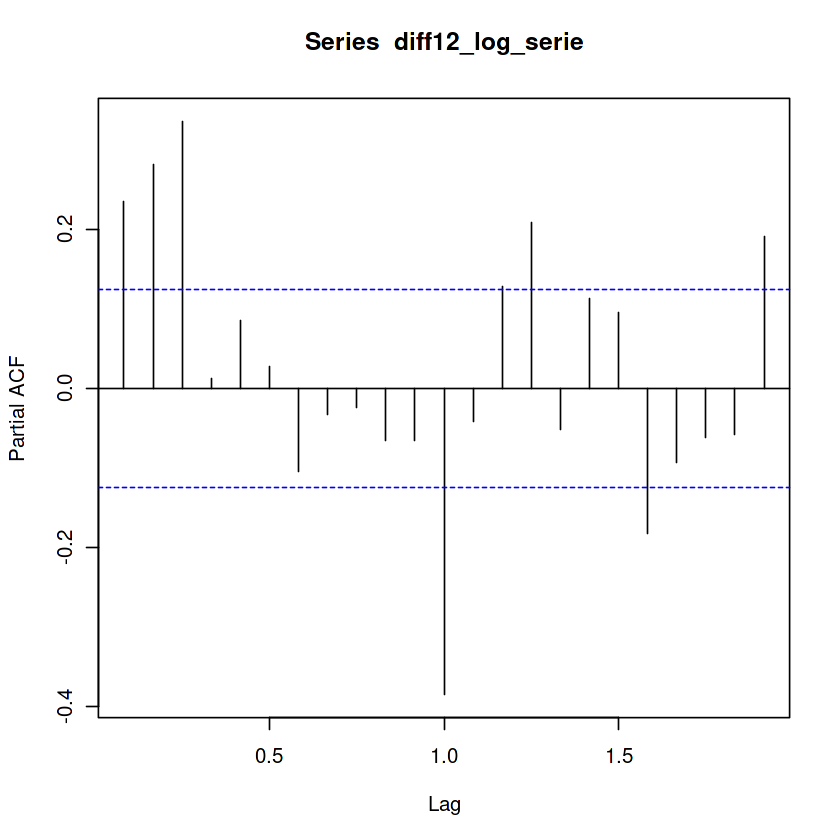

In [8]:
acf(diff12_log_serie)
pacf(diff12_log_serie)

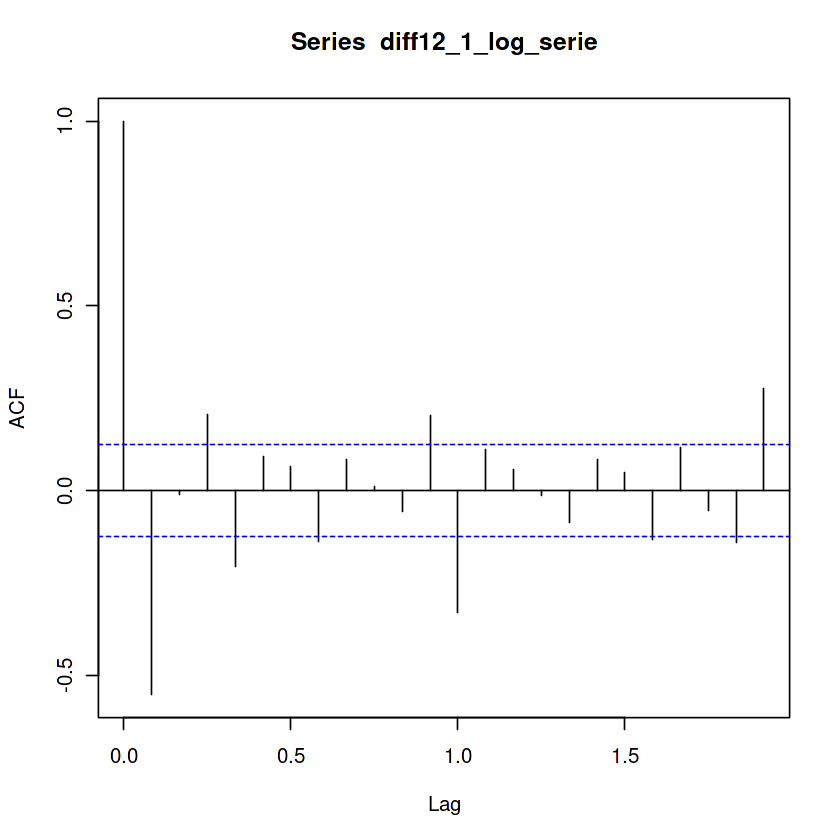

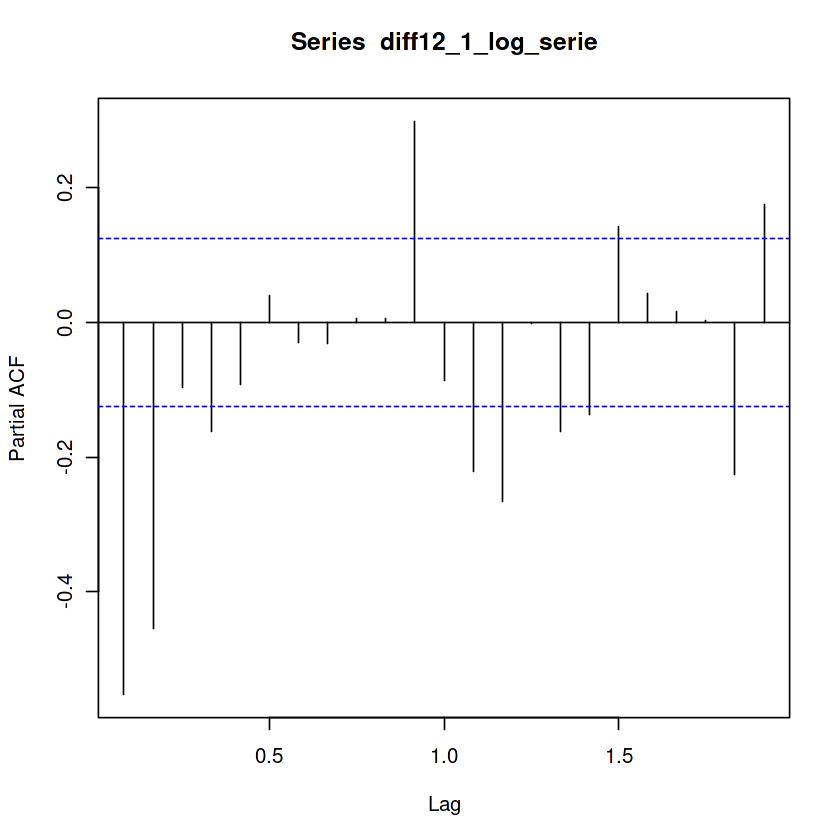

In [9]:
acf(diff12_1_log_serie)
pacf(diff12_1_log_serie)

# Test de Raices Unitarias

## 1) Hipótesis de Dickey Fuller para probar estacionaridad
* H0: La serie tiene raíces unitarias (no es estacionaria)
* H1: La serie no tiene raíces unitarias (es estacionaria)

In [10]:
# Serie Original
adf_test <- adf.test(serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)


	Augmented Dickey-Fuller Test

data:  serie
Dickey-Fuller = -2.7761, Lag order = 12, p-value = 0.249
alternative hypothesis: stationary

[1] "No rechazo la hipótesis nula, la serie no es estacionaria"


In [11]:
# Log Serie Original
adf_test <- adf.test(log_serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)


	Augmented Dickey-Fuller Test

data:  log_serie
Dickey-Fuller = -2.8487, Lag order = 12, p-value = 0.2185
alternative hypothesis: stationary

[1] "No rechazo la hipótesis nula, la serie no es estacionaria"


In [12]:
# Primera Diferencia sobre Log10 Serie Original
adf_test <- adf.test(diff_log_serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)


	Augmented Dickey-Fuller Test

data:  diff_log_serie
Dickey-Fuller = -4.8894, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary

[1] "Rechazo la hipótesis nula, la serie es estacionaria"


In [13]:
# Primera Diferencia estacional sobre Log10 Serie Original
adf_test <- adf.test(diff12_log_serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)


	Augmented Dickey-Fuller Test

data:  diff12_log_serie
Dickey-Fuller = -5.7613, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary

[1] "Rechazo la hipótesis nula, la serie es estacionaria"


In [14]:
# Primera Diferencia sobre una serie diferenciada estacionalmente que ya tuvo Log10
adf_test <- adf.test(diff12_1_log_serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)


	Augmented Dickey-Fuller Test

data:  diff12_1_log_serie
Dickey-Fuller = -4.8864, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary

[1] "Rechazo la hipótesis nula, la serie es estacionaria"


In [15]:
none.df <- ur.df(log_serie, type = "none", selectlags = c("AIC"))
summary(none.df)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30333 -0.01865  0.00046  0.02091  0.21593 

Coefficients:
             Estimate Std. Error t value            Pr(>|t|)
z.lag.1    -0.0003617  0.0012776  -0.283               0.777
z.diff.lag -0.5664052  0.0517624 -10.942 <0.0000000000000002

Residual standard error: 0.03659 on 256 degrees of freedom
Multiple R-squared:  0.3189,	Adjusted R-squared:  0.3136 
F-statistic: 59.94 on 2 and 256 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -0.2831 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


In [16]:
drift.df <- ur.df(log_serie, type = "drift", selectlags = c("AIC"))
summary(drift.df)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.281976 -0.017396 -0.000511  0.017008  0.185644 

Coefficients:
            Estimate Std. Error t value        Pr(>|t|)
(Intercept)  0.60466    0.11017   5.489 0.0000000977501
z.lag.1     -0.33944    0.06179  -5.493 0.0000000954029
z.diff.lag  -0.39680    0.05797  -6.845 0.0000000000568

Residual standard error: 0.03467 on 255 degrees of freedom
Multiple R-squared:  0.3909,	Adjusted R-squared:  0.3861 
F-statistic: 81.81 on 2 and 255 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -5.4933 15.1066 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


In [17]:
trend.df <- ur.df(log_serie, type = "trend", selectlags = c("AIC"))
summary(trend.df)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.275901 -0.018100  0.000343  0.017041  0.175062 

Coefficients:
               Estimate  Std. Error t value       Pr(>|t|)
(Intercept)  0.81449513  0.12514815   6.508 0.000000000403
z.lag.1     -0.44927553  0.06903121  -6.508 0.000000000403
tt          -0.00010761  0.00003237  -3.324        0.00102
z.diff.lag  -0.34198590  0.05920408  -5.776 0.000000022235

Residual standard error: 0.034 on 254 degrees of freedom
Multiple R-squared:  0.4163,	Adjusted R-squared:  0.4094 
F-statistic: 60.37 on 3 and 254 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -6.5083 14.1508 21.2072 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.98 -3.42 -3.13
phi2  6.15  4.71  4

## 2) KPSS
* H0: Estacionario
* H1: No estacionario

In [18]:
kpss_test <- kpss.test(log_serie)
print(kpss_test)

# Diferenciar
ndiffs(log_serie)

# Diferenciar estacionalmente
nsdiffs(log_serie)


	KPSS Test for Level Stationarity

data:  log_serie
KPSS Level = 1.4692, Truncation lag parameter = 5, p-value = 0.01



[1] 1

[1] 0

In [19]:
kpss_test_diff <- kpss.test(diff_log_serie)
print(kpss_test_diff)


	KPSS Test for Level Stationarity

data:  diff_log_serie
KPSS Level = 0.032776, Truncation lag parameter = 5, p-value = 0.1



# Particion de Datos: Train & Test

In [20]:
train <- window(log_serie, start = 2011, end = c(2017, 12), frequency = 12)
test <- window(log_serie, start = c(2018,01), end = c(2018,12))

# ARIMA Manual

### AR(1)

In [21]:
modelo1 <- arima(diff(train),c(1,0,0), method="ML")
modelo1

coeftest(modelo1)


Call:
arima(x = diff(train), order = c(1, 0, 0), method = "ML")

Coefficients:
          ar1  intercept
      -0.6057     0.0006
s.e.   0.0873     0.0016

sigma^2 estimated as 0.0005573:  log likelihood = 192.93,  aic = -379.87


z test of coefficients:

             Estimate  Std. Error z value          Pr(>|z|)
ar1       -0.60565843  0.08734167 -6.9344 0.000000000004081
intercept  0.00061301  0.00162491  0.3773             0.706


### AR(2)

In [22]:
modelo2 <- arima(diff(train),c(2,0,0), method="ML")
modelo2

coeftest(modelo2)


Call:
arima(x = diff(train), order = c(2, 0, 0), method = "ML")

Coefficients:
          ar1      ar2  intercept
      -0.9839  -0.6109     0.0005
s.e.   0.0877   0.0866     0.0008

sigma^2 estimated as 0.0003487:  log likelihood = 211.93,  aic = -415.85


z test of coefficients:

             Estimate  Std. Error  z value              Pr(>|z|)
ar1       -0.98391997  0.08769583 -11.2197 < 0.00000000000000022
ar2       -0.61092759  0.08657862  -7.0563      0.00000000000171
intercept  0.00053133  0.00080562   0.6595                0.5096


### AR(2) MA(1)

In [23]:
modelo3 <- arima(diff(train),c(2,0,1), method="ML")
modelo3

coeftest(modelo3)


Call:
arima(x = diff(train), order = c(2, 0, 1), method = "ML")

Coefficients:
          ar1      ar2     ma1  intercept
      -0.9978  -0.6194  0.0218     0.0005
s.e.   0.1310   0.1038  0.1545     0.0008

sigma^2 estimated as 0.0003486:  log likelihood = 211.94,  aic = -413.87


z test of coefficients:

             Estimate  Std. Error z value            Pr(>|z|)
ar1       -0.99784733  0.13095222 -7.6199 0.00000000000002538
ar2       -0.61936814  0.10381628 -5.9660 0.00000000243137421
ma1        0.02176069  0.15445801  0.1409              0.8880
intercept  0.00053211  0.00081568  0.6523              0.5142


### AR(3)

In [24]:
modelo4 <- arima(train,c(3,0,0), method="ML")
modelo4

coeftest(modelo4)


Call:
arima(x = train, order = c(3, 0, 0), method = "ML")

Coefficients:
          ar1     ar2     ar3  intercept
      -0.0392  0.3018  0.5534     1.7615
s.e.   0.0914  0.0856  0.0912     0.0096

sigma^2 estimated as 0.0003387:  log likelihood = 215.63,  aic = -421.26


z test of coefficients:

            Estimate Std. Error  z value              Pr(>|z|)
ar1       -0.0391629  0.0914106  -0.4284             0.6683390
ar2        0.3017822  0.0856008   3.5255             0.0004227
ar3        0.5533755  0.0911862   6.0686         0.00000000129
intercept  1.7615465  0.0096327 182.8715 < 0.00000000000000022


### AR(1) MA(2)

In [25]:
modelo5 <- arima(train,c(1,0,2),c(0,0,0), method="ML")
modelo5

coeftest(modelo5)


Call:
arima(x = train, order = c(1, 0, 2), seasonal = c(0, 0, 0), method = "ML")

Coefficients:
         ar1      ma1     ma2  intercept
      0.8393  -0.9974  0.6215     1.7629
s.e.  0.0733   0.1023  0.0870     0.0075

sigma^2 estimated as 0.0003502:  log likelihood = 214.18,  aic = -418.35


z test of coefficients:

            Estimate Std. Error  z value              Pr(>|z|)
ar1        0.8392641  0.0732981  11.4500 < 0.00000000000000022
ma1       -0.9974399  0.1023402  -9.7463 < 0.00000000000000022
ma2        0.6215363  0.0869791   7.1458    0.0000000000008947
intercept  1.7628725  0.0074553 236.4592 < 0.00000000000000022


# Prediccion

### Forecast Accuracy

**Magnitude**
* Scale-dependent errors: The forecast errors are on the same scale as the data. Accuracy measures that are based only on e_t are therefore scale-dependent and cannot be used to make comparisons between series that involve different units.    
    
    A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean
    * RMSE (Root Mean Square Error):        
    * MAE (Mean Absolute Error): When comparing forecast methods applied to a single time series, or to several time series with the same units, the MAE is popular as it is easy to both understand and compute.

* Percentage errors: Percentage errors have the advantage of being unit-free, and so are frequently used to compare forecast performances between data sets.

    Measures based on percentage errors have the disadvantage of being infinite or undefined if y=0 for any **t** in the period of interest, and having extreme values if any **y** is close to zero.
    * MPE (Mean Percentage Error): 
    * MAPE (Mean Absolute Percentage Error):

* Scaled errors: They proposed scaling the errors based on the training MAE from a simple forecast method.
    * MASE (Mean Absolute Scaled Error): A scaled error is less than one if it arises from a better forecast than the average naïve forecast computed on the training data. Conversely, it is greater than one if the forecast is worse than the average naïve forecast computed on the training data.
    
    

* MAD (Mean Absolute Deviation): how far off on average our forescast are to the actual value. 
    Cuanto mayor es el MAD, pero es la calidad de la prediccion
* MSE (Mean Square Error):

**Bias**
* ME (Mean Error):

## Promedio Simple

         Point Forecast    Lo 80   Hi 80    Lo 95    Hi 95
Jan 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Feb 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Mar 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Apr 2018       1.762486 1.729633 1.79534 1.711904 1.813069
May 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Jun 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Jul 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Aug 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Sep 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Oct 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Nov 2018       1.762486 1.729633 1.79534 1.711904 1.813069
Dec 2018       1.762486 1.729633 1.79534 1.711904 1.813069

ME                         RMSE       MAE        MPE        
Training set  0.00000000000000001321719 0.02513053 0.01950516 -0.02034972
Test set     -0.00613890303027087025356 0.02069194 0.01421101 -0.36241987
             MAPE      MASE      ACF1       Theil's U
Training set 1.1073966 0.7443311  0.2893855        NA
Test set     0.8185073 0.5423026 -0.0590752 0.7728631

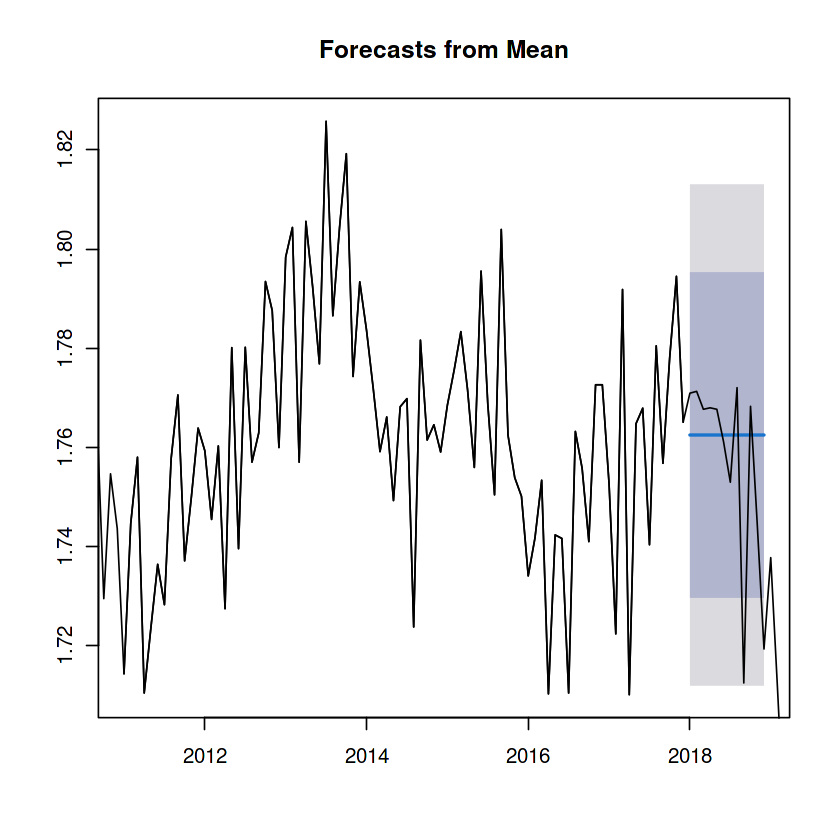

In [26]:
simple_average <- meanf(train, h = 12)
simple_average

accuracy(simple_average, test)

plot(simple_average, type = "l")
lines(log_serie)

## Naive Bayes

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       1.765072 1.727047 1.803097 1.706918 1.823226
Feb 2018       1.765072 1.711297 1.818847 1.682830 1.847314
Mar 2018       1.765072 1.699211 1.830933 1.664347 1.865798
Apr 2018       1.765072 1.689023 1.841122 1.648765 1.881380
May 2018       1.765072 1.680046 1.850098 1.635036 1.895108
Jun 2018       1.765072 1.671931 1.858213 1.622625 1.907519
Jul 2018       1.765072 1.664468 1.865676 1.611212 1.918933
Aug 2018       1.765072 1.657522 1.872622 1.600588 1.929556
Sep 2018       1.765072 1.650998 1.879146 1.590611 1.939534
Oct 2018       1.765072 1.644827 1.885317 1.581174 1.948971
Nov 2018       1.765072 1.638958 1.891186 1.572198 1.957947
Dec 2018       1.765072 1.633351 1.896794 1.563621 1.966523

ME            RMSE       MAE        MPE         MAPE     
Training set  0.0006113547 0.02967088 0.02404421  0.02094586 1.3641766
Test set     -0.0087247099 0.02160072 0.01378004 -0.50966517 0.7952559
             MASE      ACF1       Theil's U
Training set 0.9175447 -0.5981671        NA
Test set     0.5258566 -0.0590752 0.8099049

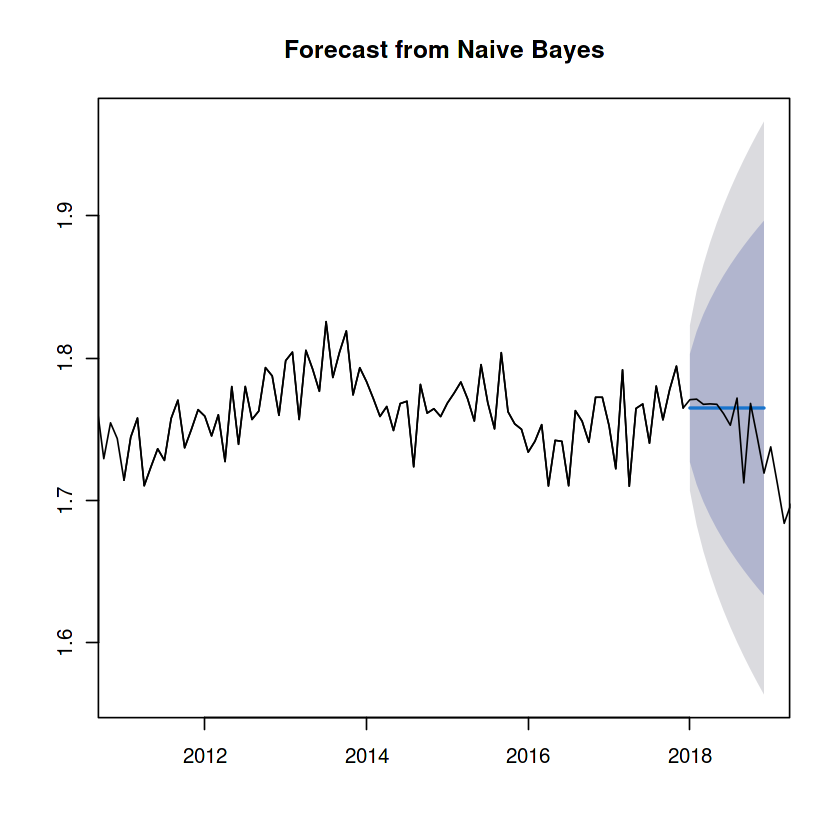

In [27]:
naive_ingenuo <- rwf(train, h = 12)
naive_ingenuo

accuracy(naive_ingenuo, test)

plot(naive_ingenuo, type = "l", main = "Forecast from Naive Bayes")
lines(log_serie)

## Drift

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       1.765684 1.727436 1.803931 1.707189 1.824179
Feb 2018       1.766295 1.711879 1.820710 1.683074 1.849516
Mar 2018       1.766906 1.699866 1.833947 1.664377 1.869436
Apr 2018       1.767518 1.689652 1.845383 1.648432 1.886603
May 2018       1.768129 1.680568 1.855690 1.634216 1.902042
Jun 2018       1.768740 1.672272 1.865209 1.621205 1.916276
Jul 2018       1.769352 1.664564 1.874140 1.609092 1.929611
Aug 2018       1.769963 1.657312 1.882614 1.597679 1.942247
Sep 2018       1.770574 1.650428 1.890720 1.586827 1.954322
Oct 2018       1.771186 1.643847 1.898525 1.576438 1.965934
Nov 2018       1.771797 1.637519 1.906075 1.566437 1.977158
Dec 2018       1.772408 1.631408 1.913409 1.556766 1.988051

ME                         RMSE       MAE        MPE        
Training set -0.00000000000000007758226 0.02966458 0.02405158 -0.01373661
Test set     -0.01269851552613626699539 0.02471986 0.01495331 -0.73684831
             MAPE      MASE      ACF1       Theil's U
Training set 1.3648194 0.9178258 -0.5981671        NA
Test set     0.8641699 0.5706294  0.0402001 0.9281118

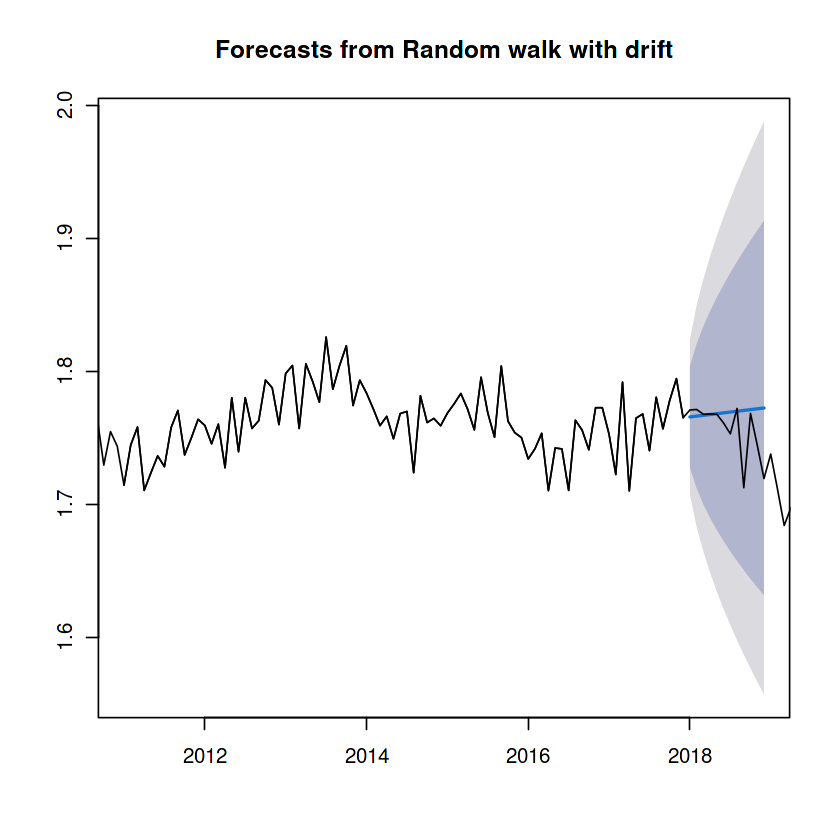

In [28]:
drift <- rwf(train, h = 12, drift=TRUE)
drift

accuracy(drift, test)

plot(drift, type = "l")
lines(log_serie)

## Naive Estacional

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       1.752663 1.711048 1.794278 1.689018 1.816308
Feb 2018       1.722387 1.680772 1.764003 1.658742 1.786032
Mar 2018       1.791831 1.750216 1.833446 1.728186 1.855476
Apr 2018       1.710117 1.668502 1.751733 1.646472 1.773763
May 2018       1.764774 1.723158 1.806389 1.701128 1.828419
Jun 2018       1.767898 1.726282 1.809513 1.704252 1.831543
Jul 2018       1.740363 1.698747 1.781978 1.676717 1.804008
Aug 2018       1.780461 1.738846 1.822077 1.716816 1.844107
Sep 2018       1.756788 1.715173 1.798404 1.693143 1.820433
Oct 2018       1.778079 1.736463 1.819694 1.714434 1.841724
Nov 2018       1.794488 1.752873 1.836103 1.730843 1.858133
Dec 2018       1.765072 1.723457 1.806688 1.701427 1.828717

ME           RMSE       MAE        MPE        MAPE     MASE    
Training set  0.003192560 0.03247269 0.02620495  0.1647509 1.481999 1.000000
Test set     -0.004062593 0.03366019 0.02748460 -0.2459456 1.570611 1.048833
             ACF1      Theil's U
Training set 0.4210182       NA 
Test set     0.1310303 1.247323

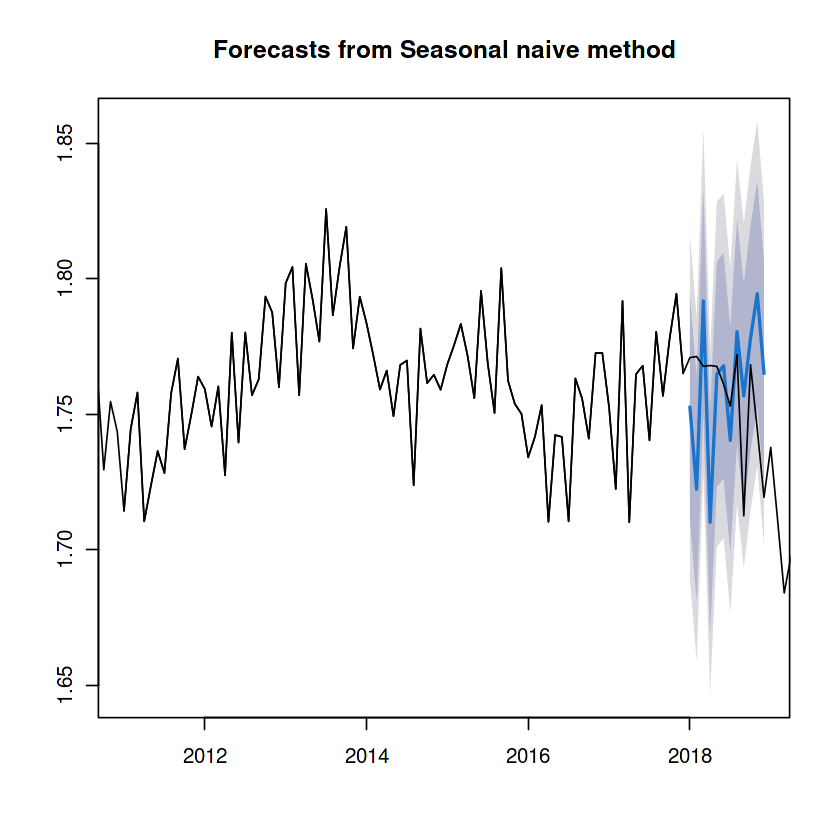

In [29]:
naive_estacional <- snaive(train, h = 12)
naive_estacional

# Testing the accuracy of the mean baseline forecast values against the actual values
accuracy(naive_estacional, test)

plot(naive_estacional, type = "l")
lines(log_serie)

## Holt Winters

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       1.753154 1.722770 1.783538 1.706686 1.799622
Feb 2018       1.736693 1.704686 1.768699 1.687743 1.785643
Mar 2018       1.796858 1.763243 1.830473 1.745448 1.848267
Apr 2018       1.724668 1.689456 1.759880 1.670816 1.778520
May 2018       1.776255 1.739454 1.813055 1.719974 1.832535
Jun 2018       1.777967 1.739585 1.816349 1.719267 1.836667
Jul 2018       1.750849 1.710890 1.790808 1.689736 1.811962
Aug 2018       1.789509 1.747975 1.831043 1.725989 1.853030
Sep 2018       1.772309 1.729202 1.815416 1.706383 1.838235
Oct 2018       1.785895 1.741216 1.830574 1.717564 1.854226
Nov 2018       1.798082 1.751830 1.844334 1.727345 1.868818
Dec 2018       1.772733 1.724906 1.820559 1.699588 1.845877

ME           RMSE       MAE        MPE        MAPE     MASE     
Training set -0.002392819 0.02366478 0.01951449 -0.1439990 1.105191 0.7446872
Test set     -0.013233439 0.03479256 0.02953292 -0.7686745 1.689886 1.1269981
             ACF1       Theil's U
Training set -0.2724739       NA 
Test set      0.1727635 1.292451

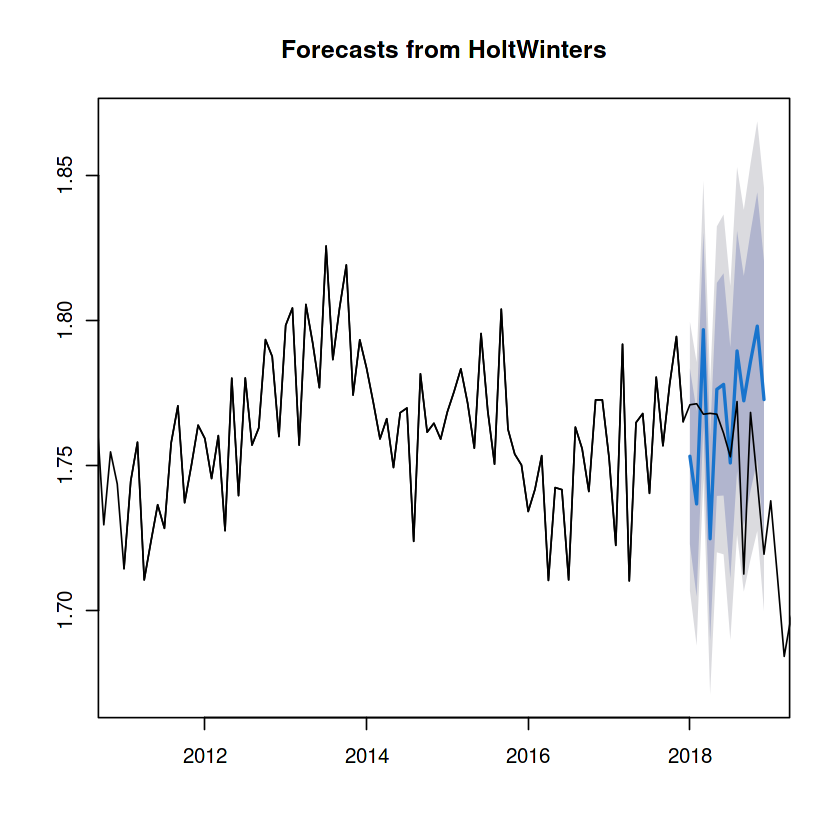

In [30]:
exphw <- HoltWinters(train)

expforecast <- forecast(exphw, h = 12)
expforecast

# Testing the accuracy of the mean baseline forecast values against the actual values
accuracy(expforecast, test)

plot(expforecast, type = "l")
lines(log_serie)

## ARIMA


Call:
arima(x = train, order = c(2, 1, 0), seasonal = c(0, 0, 0), method = "ML")

Coefficients:
          ar1      ar2
      -0.9820  -0.6093
s.e.   0.0879   0.0868

sigma^2 estimated as 0.0003505:  log likelihood = 211.71,  aic = -417.41

[1] 83

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       1.783960 1.759965 1.807954 1.747264 1.820656
Feb 2018       1.783336 1.759338 1.807334 1.746634 1.820038
Mar 2018       1.772440 1.746827 1.798053 1.733269 1.811611
Apr 2018       1.783520 1.753867 1.813173 1.738170 1.828870
May 2018       1.779279 1.749375 1.809183 1.733545 1.825013
Jun 2018       1.776692 1.744798 1.808587 1.727914 1.825471
Jul 2018       1.781816 1.748160 1.815472 1.730344 1.833289
Aug 2018       1.778361 1.744047 1.812674 1.725883 1.830838
Sep 2018       1.778632 1.742634 1.814630 1.723578 1.833686
Oct 2018       1.780471 1.743307 1.817635 1.723634 1.837308
Nov 2018       1.778500 1.740422 1.816578 1.720264 1.836735
Dec 2018       1.779315 1.739889 1.818741 1.719018 1.839612

ME           RMSE       MAE        MPE         MAPE      MASE     
Training set  0.001677436 0.01861198 0.01545931  0.08674718 0.8779247 0.5899384
Test set     -0.023345928 0.03042968 0.02334593 -1.34193471 1.3419347 0.8908977
             ACF1        Theil's U
Training set  0.01929101      NA  
Test set     -0.09066682 1.13579

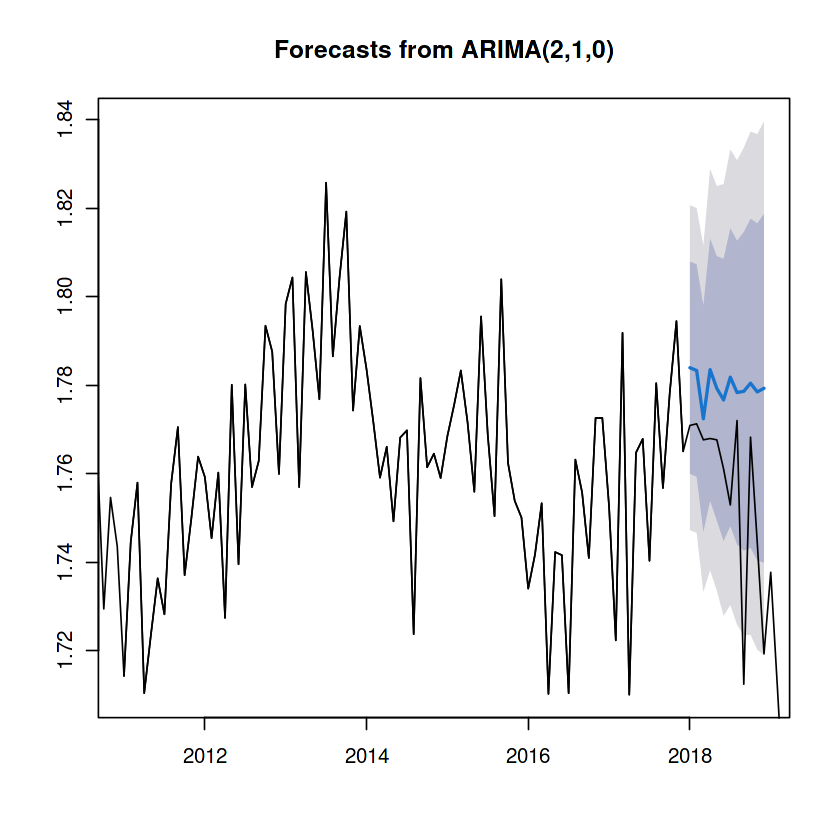

In [31]:
ArimaFit <- arima(train,c(2,1,0),c(0,0,0), method="ML")
ArimaFit

ArimaFit$nobs
Arimaforecast <- forecast(ArimaFit, h = 12)
Arimaforecast

accuracy(Arimaforecast, test)

plot(Arimaforecast)
lines(log_serie)

In [32]:
resultsDF <- NULL
resultsDF <- rbind(accuracy(simple_average, test)[2,], resultsDF)
resultsDF <- rbind(accuracy(naive_ingenuo, test)[2,], resultsDF)
resultsDF <- rbind(accuracy(drift, test)[2,], resultsDF)
resultsDF <- rbind(accuracy(naive_estacional, test)[2,], resultsDF)
resultsDF <- rbind(accuracy(expforecast, test)[2,], resultsDF)
resultsDF <- rbind(accuracy(Arimaforecast, test)[2,], resultsDF)
resultsDF <- cbind(c("Simple Avg", "Naive Bayes", "Drift", "Naive Estacional","Holt Winters", 'ARIMA'),resultsDF)

resultsDF

ME                   RMSE              
[1,] Simple Avg       -0.0233459276953922  0.0304296765406849
[2,] Naive Bayes      -0.0132334392929128  0.0347925558611051
[3,] Drift            -0.00406259326130872 0.0336601916916124
[4,] Naive Estacional -0.0126985155261363  0.0247198622735602
[5,] Holt Winters     -0.00872470987765273 0.0216007175158857
[6,] ARIMA            -0.00613890303027087 0.0206919444510889
     MAE                MPE                MAPE              MASE             
[1,] 0.0233459276953922 -1.34193470705027  1.34193470705027  0.890897738414195
[2,] 0.0295329246064099 -0.768674481409951 1.6898857872118   1.12699808223087 
[3,] 0.027484603076563  -0.245945608559422 1.57061103488728  1.04883262903939 
[4,] 0.0149533117954378 -0.736848314253018 0.86416993682307  0.570629354899749
[5,] 0.0137800433380622 -0.509665170356988 0.795255946982121 0.525856569304474
[6,] 0.0142110111459592 -0.362419873386595 0.81850734853438  0.542302617214599
     ACF1                Theil's U        
[1,] -0.0906668178382301 1.1357899242323  
[2,] 0.172763525613563   1.29245058458965 
[3,] 0.131030308161903   1.24732284257395 
[4,] 0.0402000957419179  0.928111831563064
[5,] -0.0590751966284353 0.809904864674253
[6,] -0.0590751966284353 0.772863098751459

# Analisis de los Residuos

## Simple Average


	Augmented Dickey-Fuller Test

data:  simple_average$residuals
Dickey-Fuller = -2.3267, Lag order = 12, p-value = 0.4419
alternative hypothesis: stationary


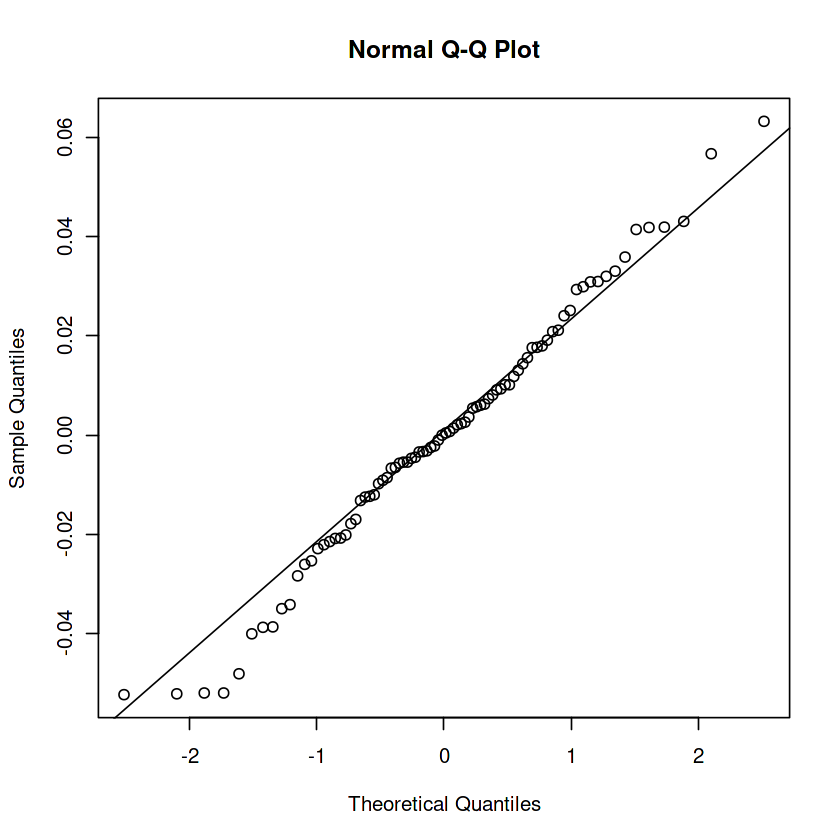


	Ljung-Box test

data:  Residuals from Mean
Q* = 91.985, df = 16, p-value = 0.000000000001076

Model df: 1.   Total lags used: 17

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n   miss                       mean                         sd                        min                        mdn                        max 
     84      0             0.000000000000             0.025281463854            -0.052369029144             0.000192111176             0.063264187093 


P_Value   Statistic 
X-squared 0.9648104 0.07164736

P_Value   Statistic
A 0.6413587 0.2783879

P_Value   Statistic
W 0.5680047 0.9870538

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.0523690 -0.0141658  0.0001921  0.0000000  0.0160980  0.0632642 

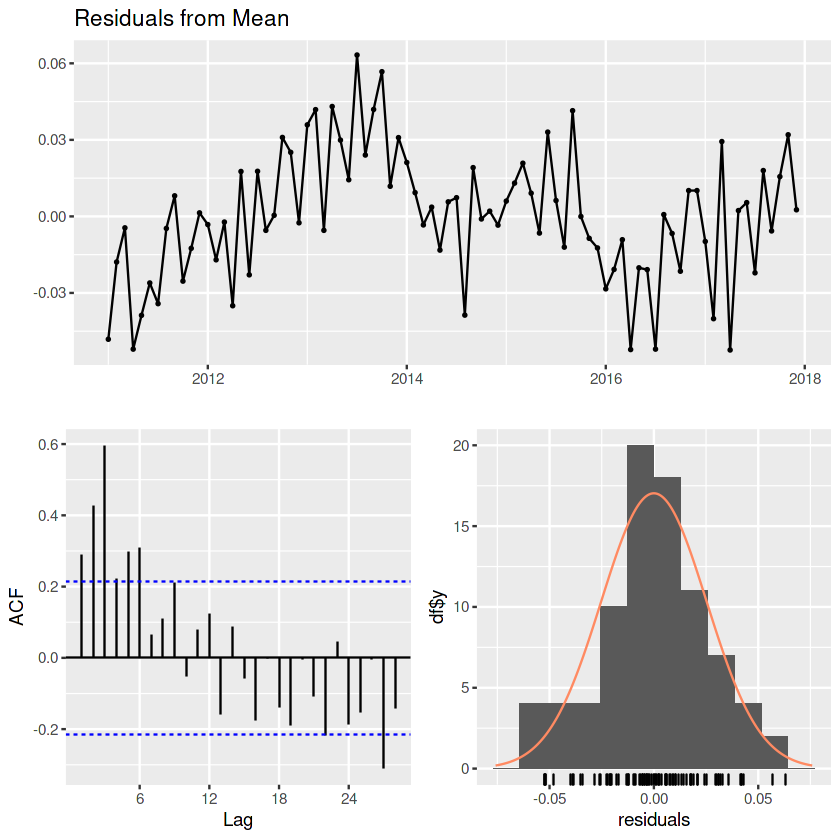

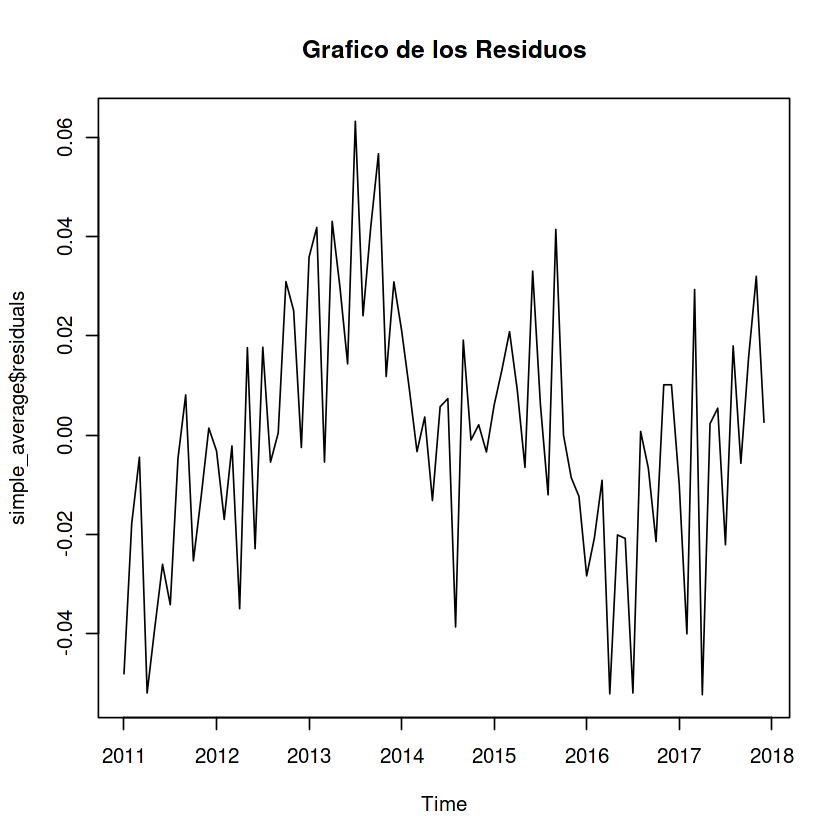

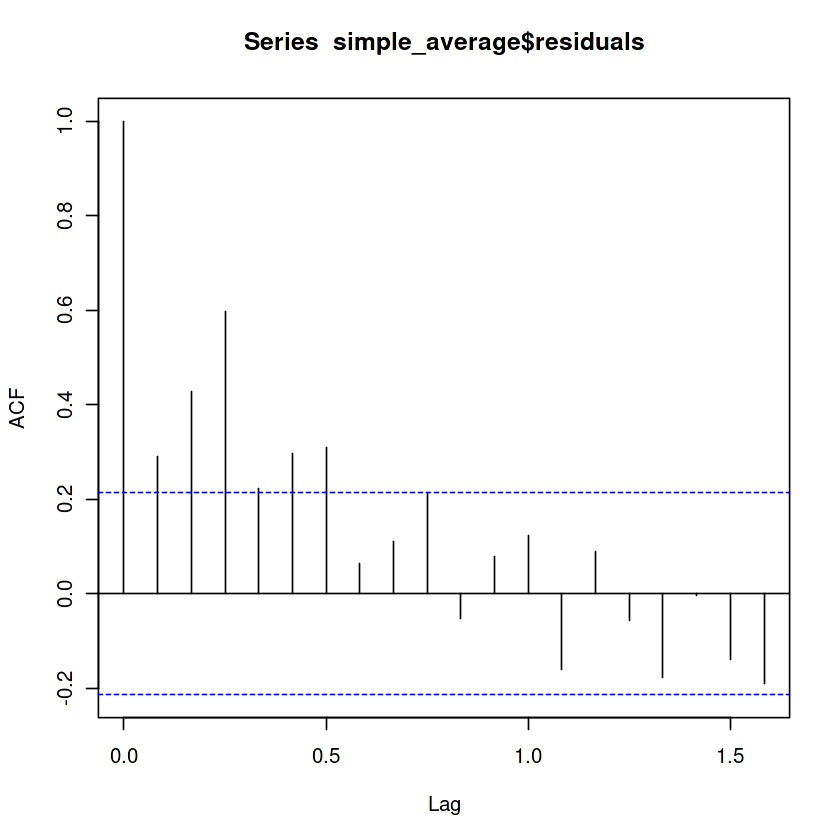

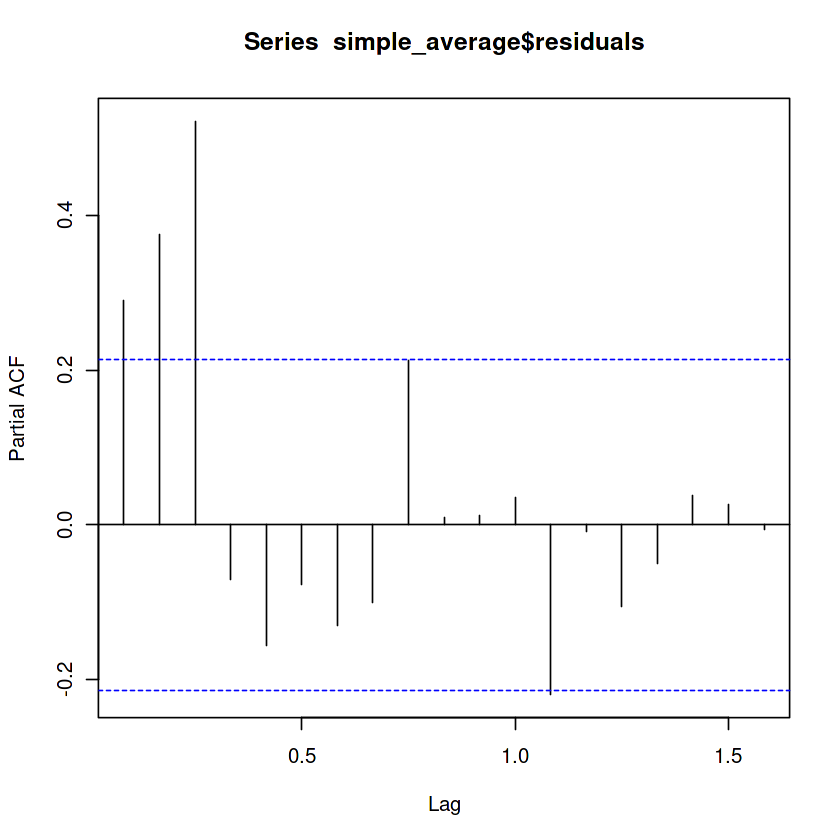

j  P_Value                Statistic
1   1 0.00693875815969346998  7.288754
2   2 0.00000824610509619905 23.411539
3   3 0.00000000000639421849 55.144981
4   4 0.00000000000352207152 59.598907
5   5 0.00000000000030975222 67.690115
6   6 0.00000000000001820766 76.577293
7   7 0.00000000000005717649 76.966537
8   8 0.00000000000011612933 78.132330
9   9 0.00000000000005206946 82.473710
10 10 0.00000000000014488410 82.749018
11 11 0.00000000000032973624 83.357461
12 12 0.00000000000047828408 84.887993
13 13 0.00000000000042088555 87.491840
14 14 0.00000000000078892448 88.315255
15 15 0.00000000000176603177 88.655273
16 16 0.00000000000107669429 91.984061
17 17 0.00000000000265409916 91.984944
18 18 0.00000000000264388511 94.088700
19 19 0.00000000000118394183 98.093818
20 20 0.00000000000275401923 98.097815
21 21 0.00000000000361866093 99.444120

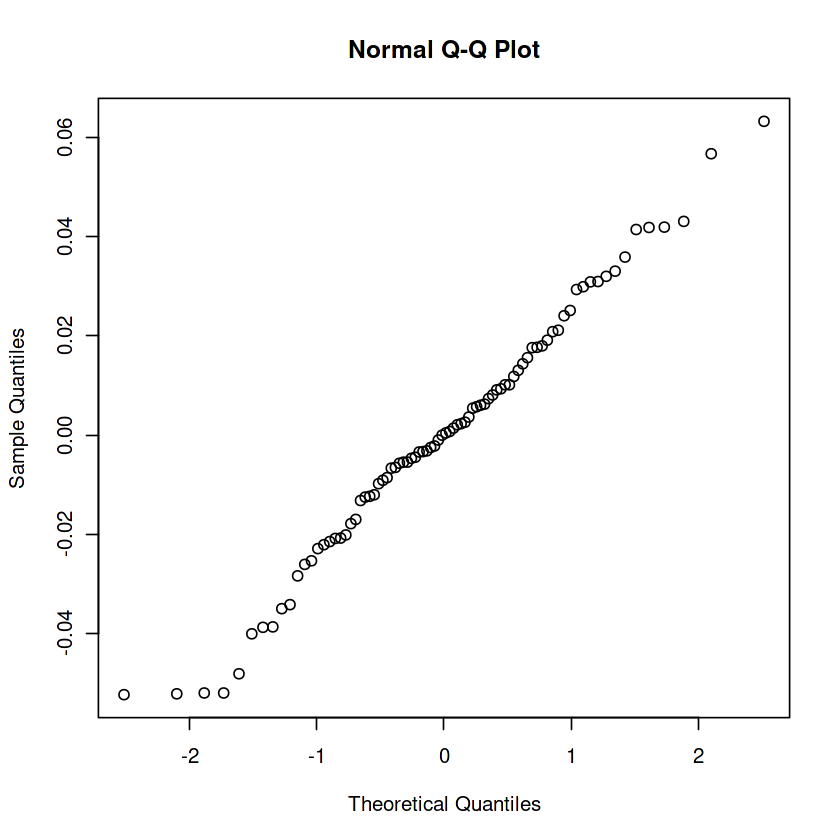

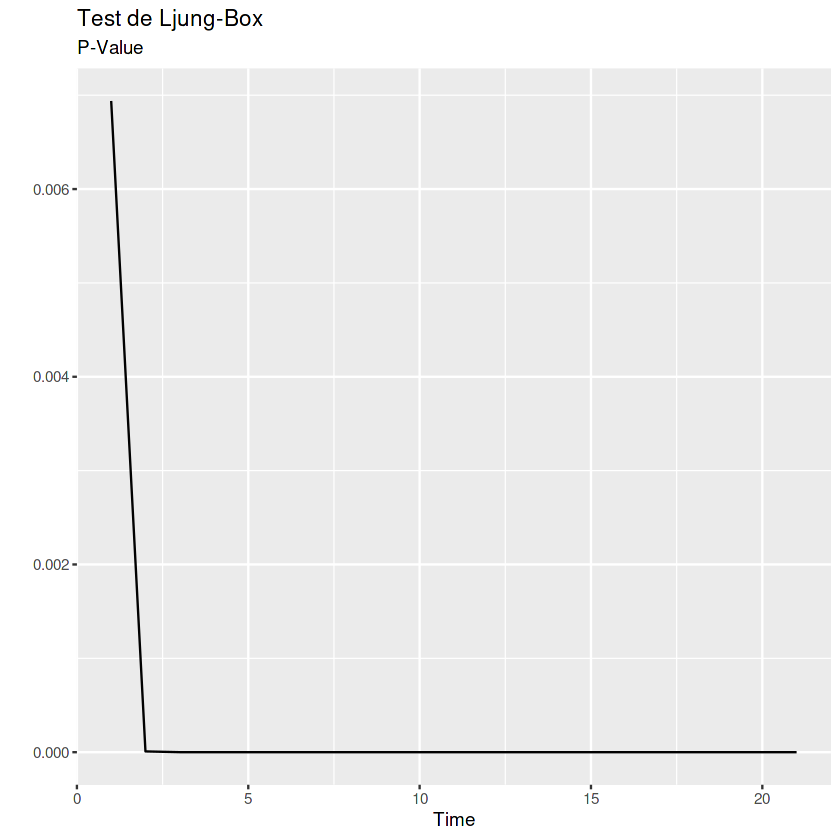

In [33]:
qqnorm(residuals(simple_average))
qqline(residuals(simple_average))

adf.test(simple_average$residuals, alternative = "stationary", k = 12)

checkresiduals(simple_average)

# Otra forma
residuos <- resid(simple_average)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)

# Gráficos de los residuos, ACF, PACF y qq norm
plot(simple_average$residuals, main = "Grafico de los Residuos")
acf(simple_average$residuals, na.action = na.pass)
pacf(simple_average$residuals, na.action = na.pass)
qqnorm(simple_average$residuals)

# Testeo de Incorrelación de los Residuos

Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

## Naive Bayes


	Augmented Dickey-Fuller Test

data:  na.omit(naive_ingenuo$residuals)
Dickey-Fuller = -2.4572, Lag order = 12, p-value = 0.3884
alternative hypothesis: stationary


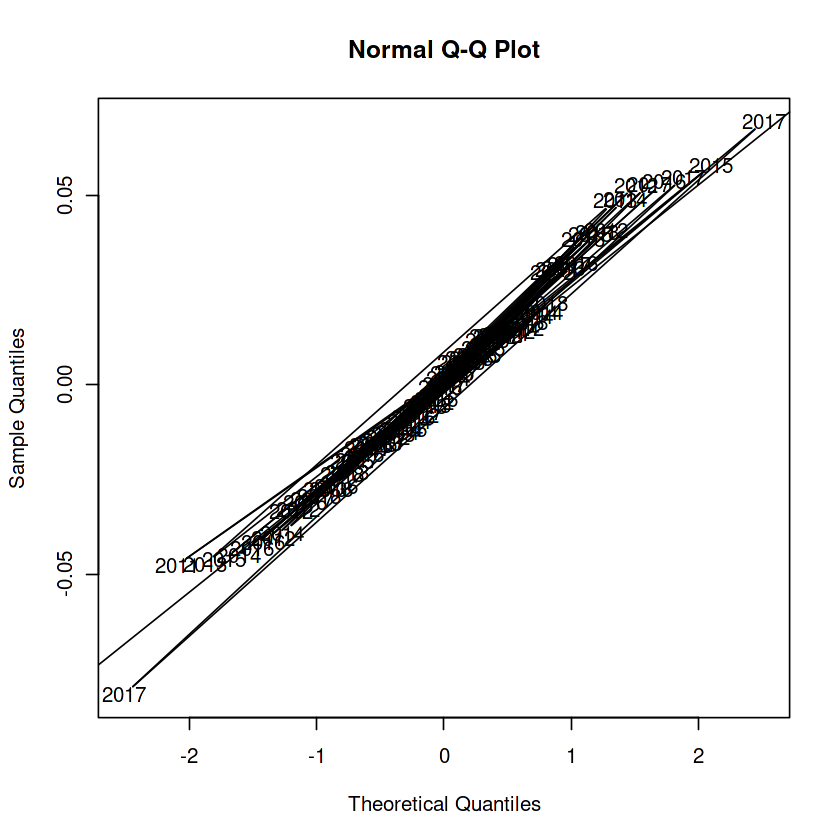


	Ljung-Box test

data:  Residuals from Random walk
Q* = 110.05, df = 17, p-value = 0.000000000000001221

Model df: 0.   Total lags used: 17

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n   miss                     mean                       sd                      min                      mdn                      max 
     83      1            0.00061135472            0.02984490968           -0.08171358256            0.00000000000            0.06944385350 


P_Value   Statistic
X-squared 0.8526126 0.3189001

P_Value   Statistic
A 0.5681762 0.3023643

P_Value  Statistic
W 0.597984 0.9873758

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max.       NA's 
-0.0817136 -0.0191165  0.0000000  0.0006114  0.0171414  0.0694439          1 

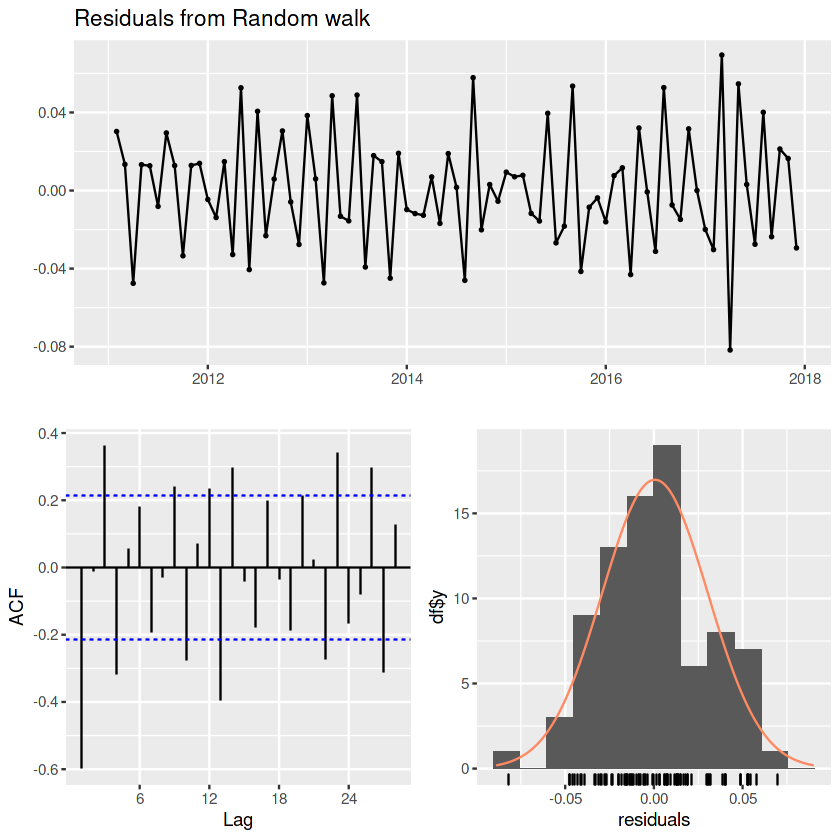

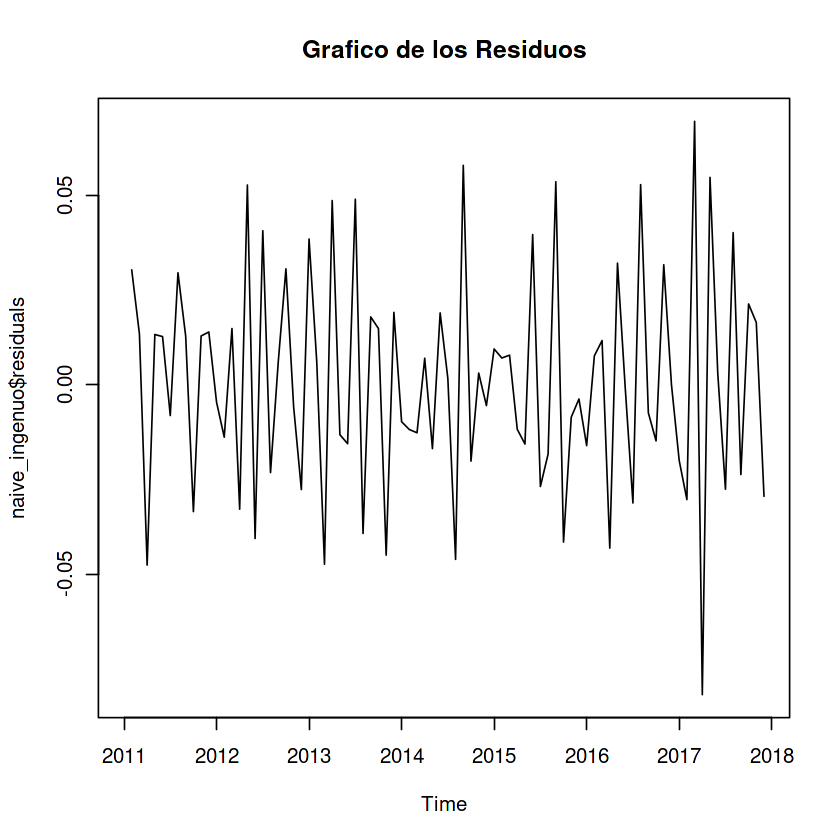

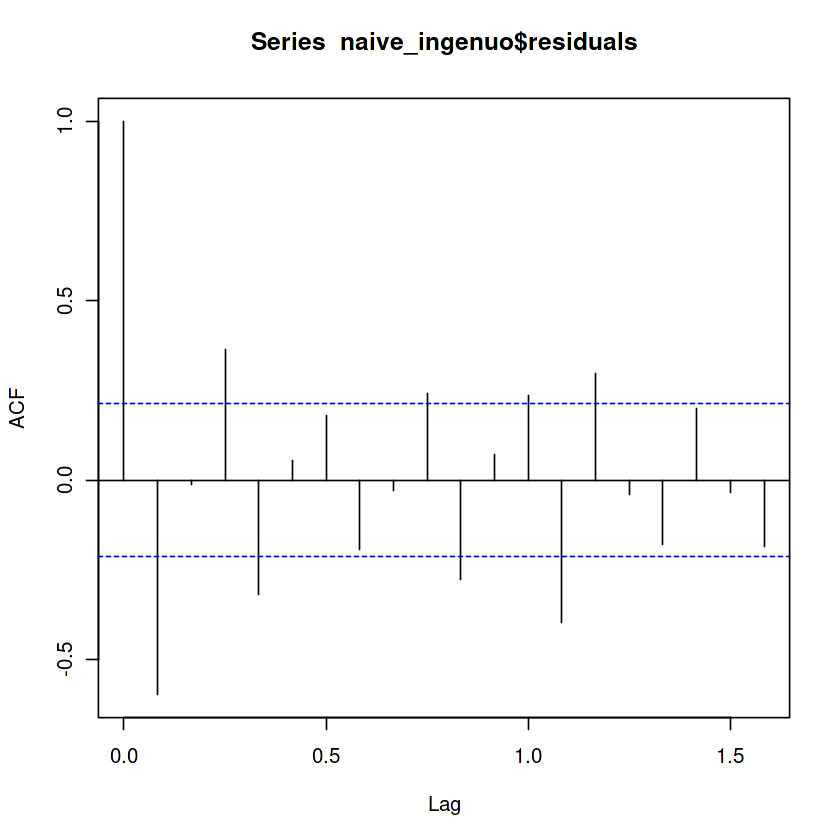

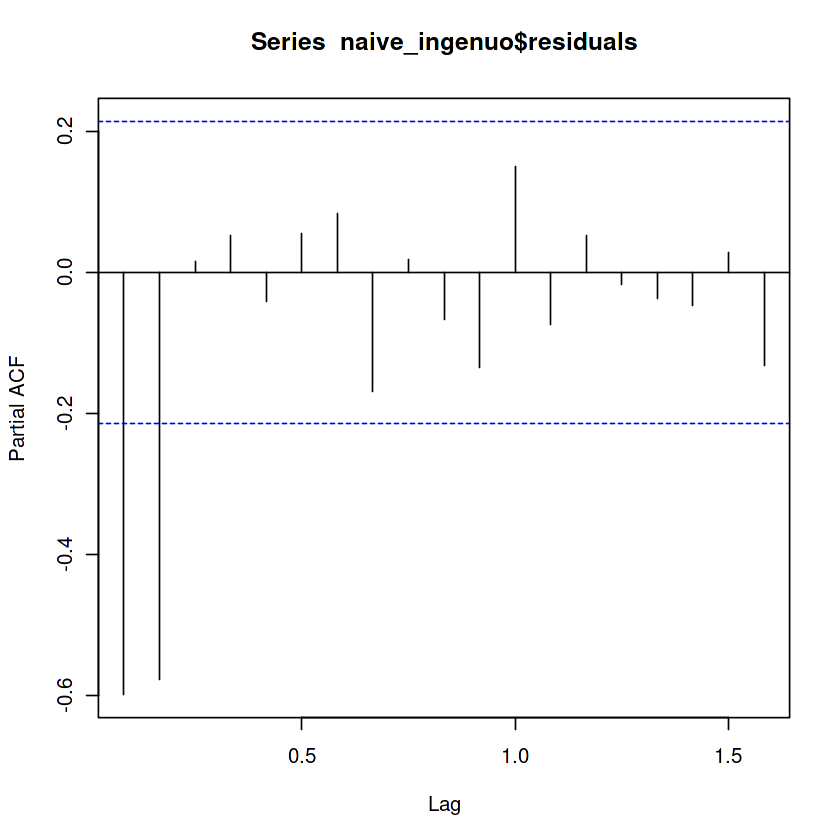

j  P_Value                  Statistic
1   1 0.0000000288372645762536  30.78422
2   2 0.0000002052143935893369  30.79842
3   3 0.0000000032208916644905  42.44950
4   4 0.0000000001710158681334  51.55360
5   5 0.0000000005838629579813  51.83256
6   6 0.0000000005048994555779  54.81620
7   7 0.0000000003367912615460  58.25231
8   8 0.0000000009886473861798  58.33296
9   9 0.0000000002387502417989  63.87423
10 10 0.0000000000248674414394  71.29930
11 11 0.0000000000556868995361  71.79192
12 12 0.0000000000136638478310  77.26777
13 13 0.0000000000000355271368  93.10276
14 14 0.0000000000000017763568 102.20164
15 15 0.0000000000000046629367 102.38088
16 16 0.0000000000000028865799 105.76089
17 17 0.0000000000000012212453 110.05421
18 18 0.0000000000000028865799 110.19126
19 19 0.0000000000000014432899 114.00539
20 20 0.0000000000000004440892 119.09989
21 21 0.0000000000000009992007 119.16494

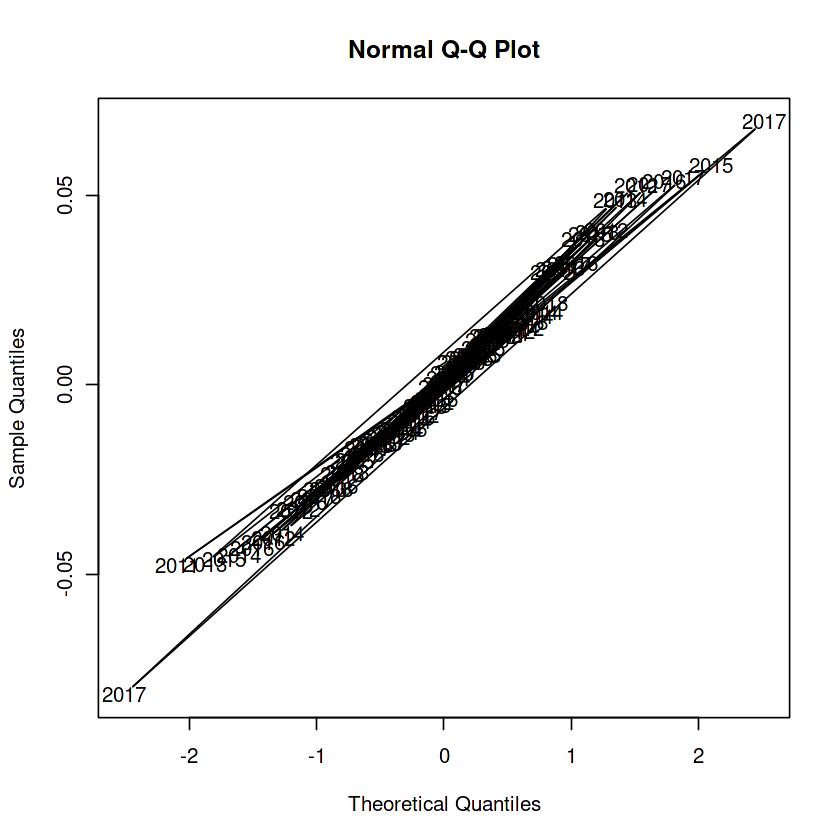

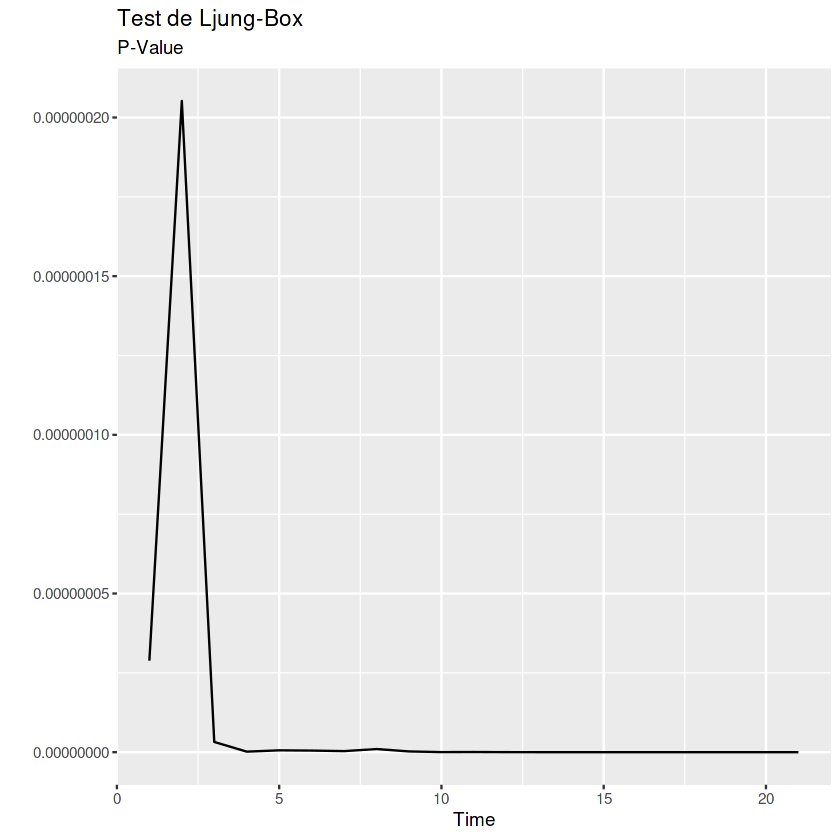

In [34]:
qqnorm(residuals(naive_ingenuo))
qqline(residuals(naive_ingenuo))

adf.test(na.omit(naive_ingenuo$residuals), alternative = "stationary", k = 12)

checkresiduals(naive_ingenuo)

# Otra forma
residuos <- resid(naive_ingenuo)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)


# Gráficos de los residuos, ACF, PACF y qq norm
plot(naive_ingenuo$residuals, main = "Grafico de los Residuos")
acf(naive_ingenuo$residuals, na.action = na.pass)
pacf(naive_ingenuo$residuals, na.action = na.pass)
qqnorm(naive_ingenuo$residuals)

# Testeo de Incorrelación de los Residuos
Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

## Drift


	Augmented Dickey-Fuller Test

data:  na.omit(drift$residuals)
Dickey-Fuller = -2.4572, Lag order = 12, p-value = 0.3884
alternative hypothesis: stationary


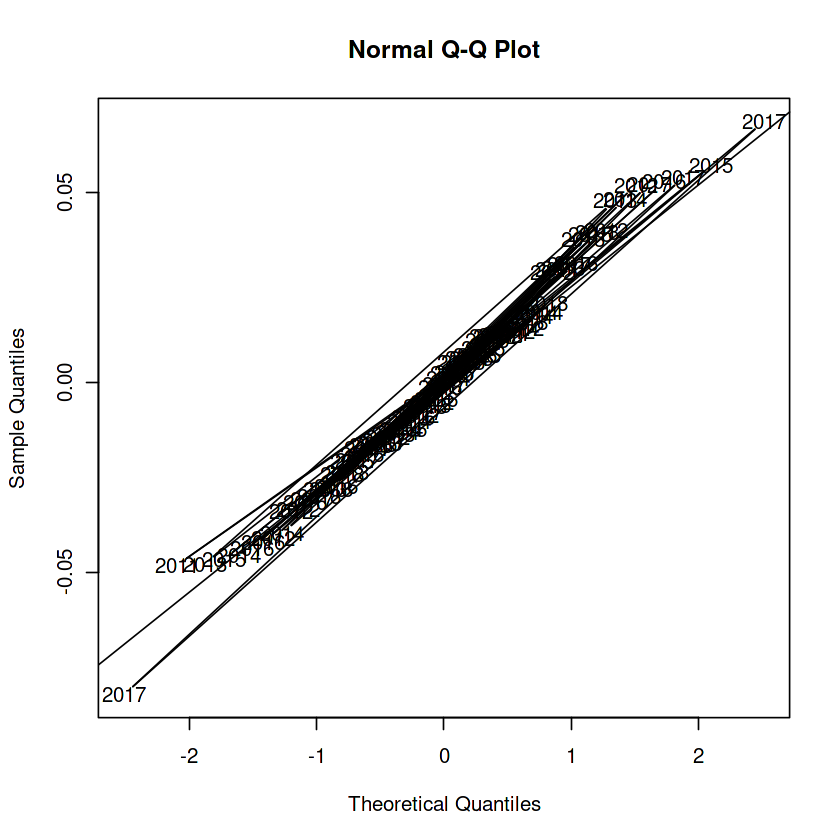


	Ljung-Box test

data:  Residuals from Random walk with drift
Q* = 110.05, df = 16, p-value = 0.0000000000000004441

Model df: 1.   Total lags used: 17

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n   miss                     mean                       sd                      min                      mdn                      max 
     83      1           -0.00000000000            0.02984490968           -0.08232493728           -0.00061135472            0.06883249878 


P_Value   Statistic
X-squared 0.8526126 0.3189001

P_Value   Statistic
A 0.5681762 0.3023643

P_Value  Statistic
W 0.597984 0.9873758

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max.       NA's 
-0.0823249 -0.0197278 -0.0006114  0.0000000  0.0165300  0.0688325          1 

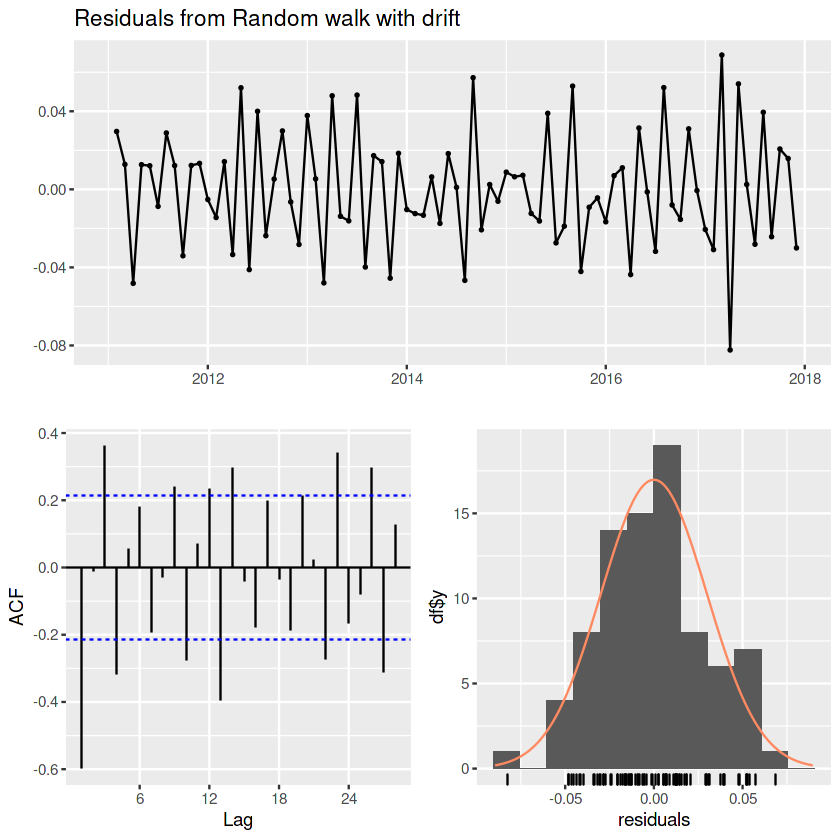

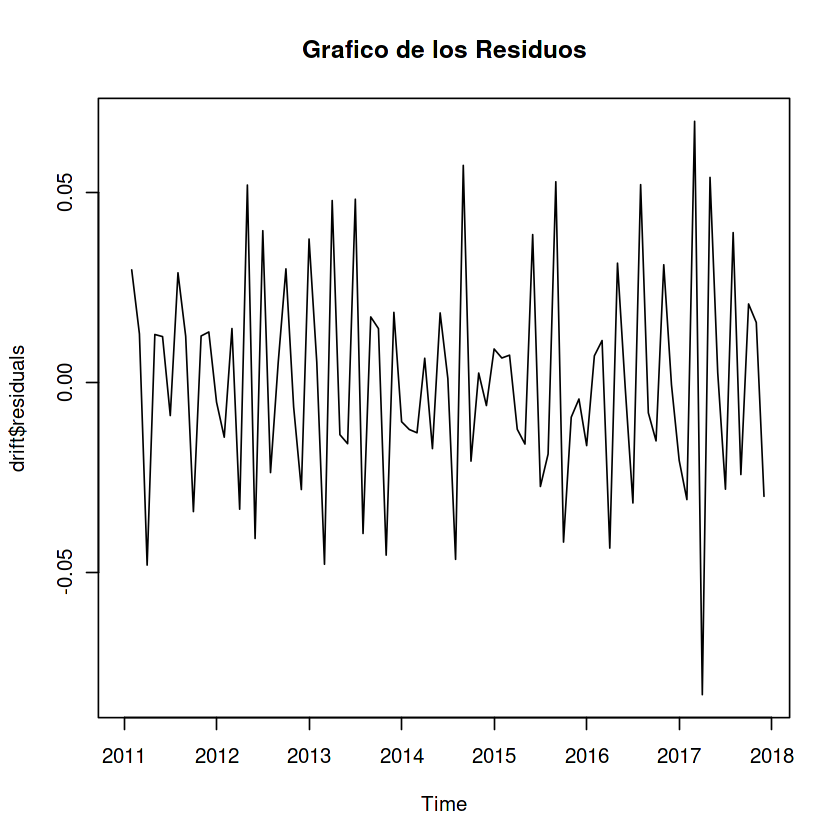

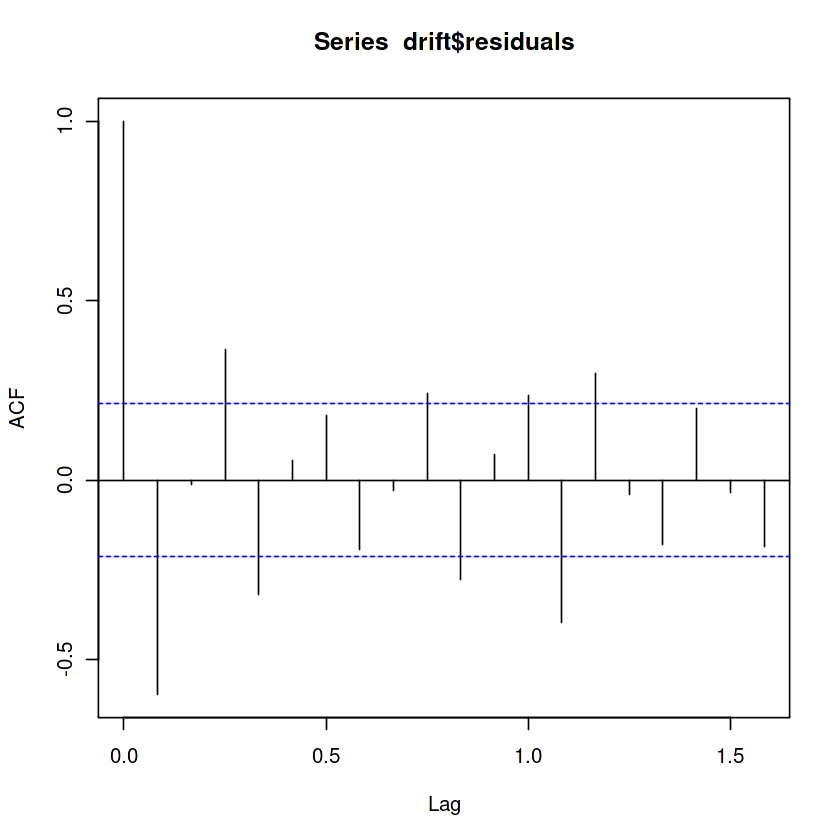

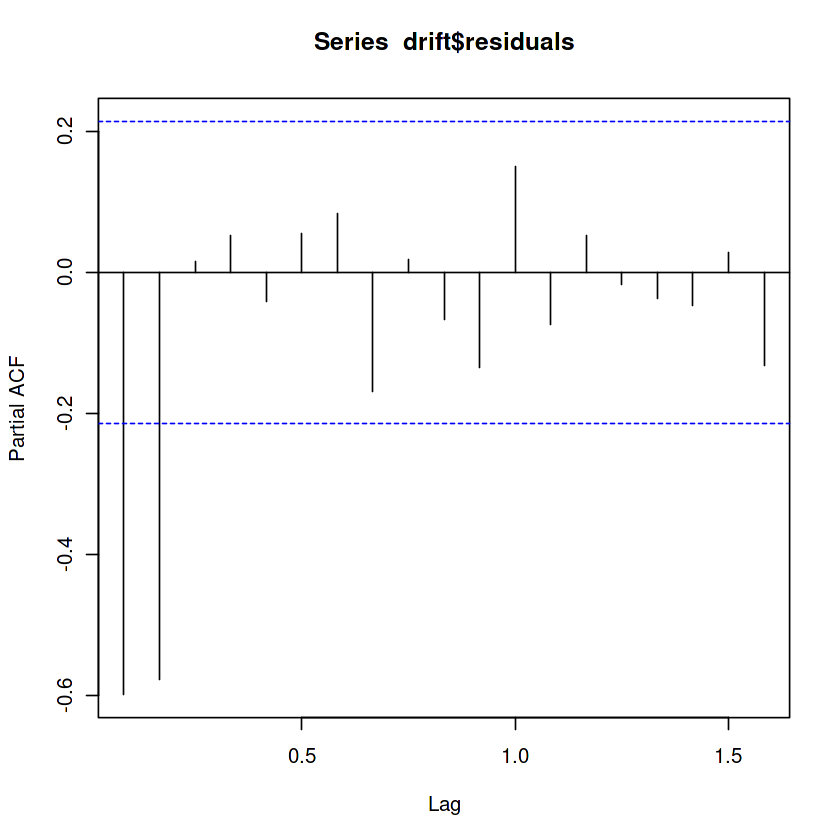

j  P_Value                  Statistic
1   1 0.0000000288372645762536  30.78422
2   2 0.0000002052143935893369  30.79842
3   3 0.0000000032208916644905  42.44950
4   4 0.0000000001710158681334  51.55360
5   5 0.0000000005838629579813  51.83256
6   6 0.0000000005048994555779  54.81620
7   7 0.0000000003367912615460  58.25231
8   8 0.0000000009886473861798  58.33296
9   9 0.0000000002387502417989  63.87423
10 10 0.0000000000248674414394  71.29930
11 11 0.0000000000556868995361  71.79192
12 12 0.0000000000136638478310  77.26777
13 13 0.0000000000000355271368  93.10276
14 14 0.0000000000000017763568 102.20164
15 15 0.0000000000000046629367 102.38088
16 16 0.0000000000000028865799 105.76089
17 17 0.0000000000000012212453 110.05421
18 18 0.0000000000000028865799 110.19126
19 19 0.0000000000000014432899 114.00539
20 20 0.0000000000000004440892 119.09989
21 21 0.0000000000000009992007 119.16494

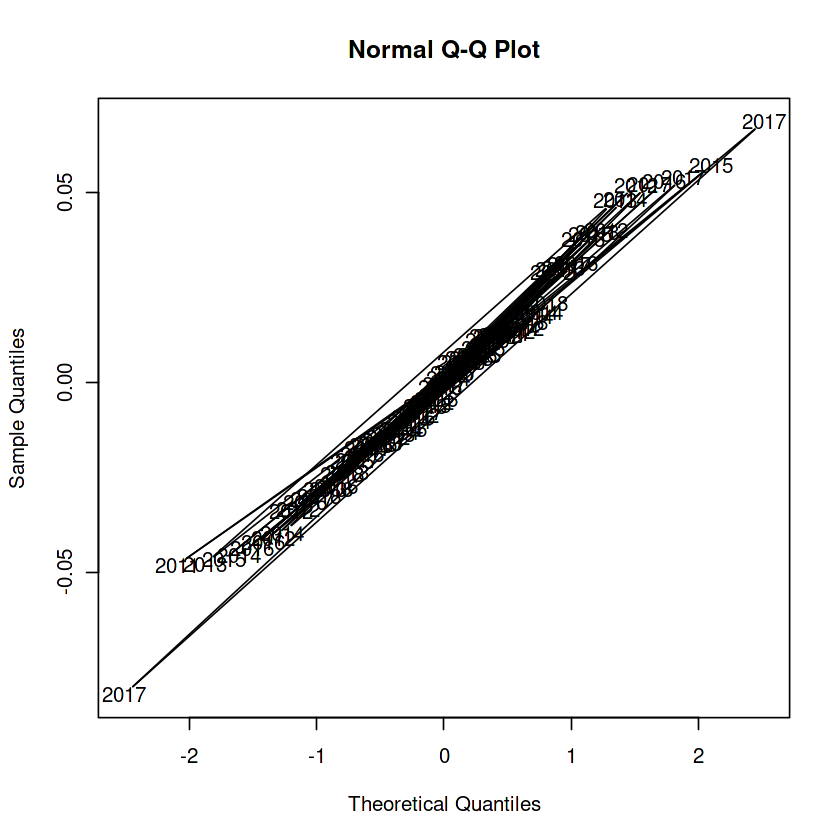

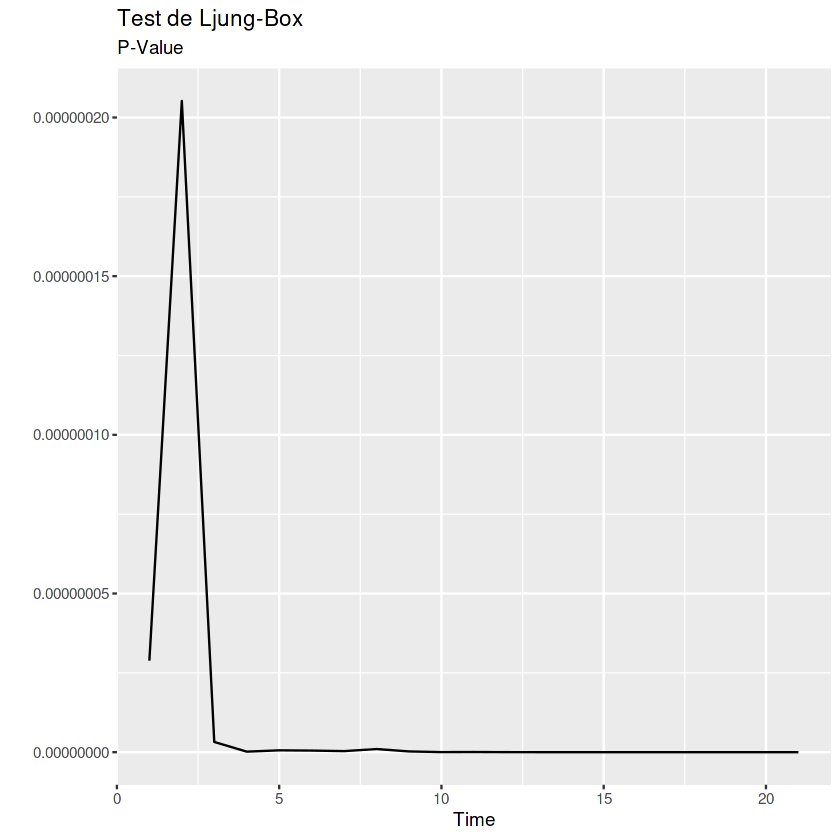

In [35]:
qqnorm(residuals(drift))
qqline(residuals(drift))

adf.test(na.omit(drift$residuals), alternative = "stationary", k = 12)

checkresiduals(drift)

# Otra forma
residuos <- resid(drift)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)


# Gráficos de los residuos, ACF, PACF y qq norm
plot(drift$residuals, main = "Grafico de los Residuos")
acf(drift$residuals, na.action = na.pass)
pacf(drift$residuals, na.action = na.pass)
qqnorm(drift$residuals)

# Testeo de Incorrelación de los Residuos
Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

## Naive Estacional


	Augmented Dickey-Fuller Test

data:  na.omit(naive_estacional$residuals)
Dickey-Fuller = -2.1122, Lag order = 4, p-value = 0.5296
alternative hypothesis: stationary


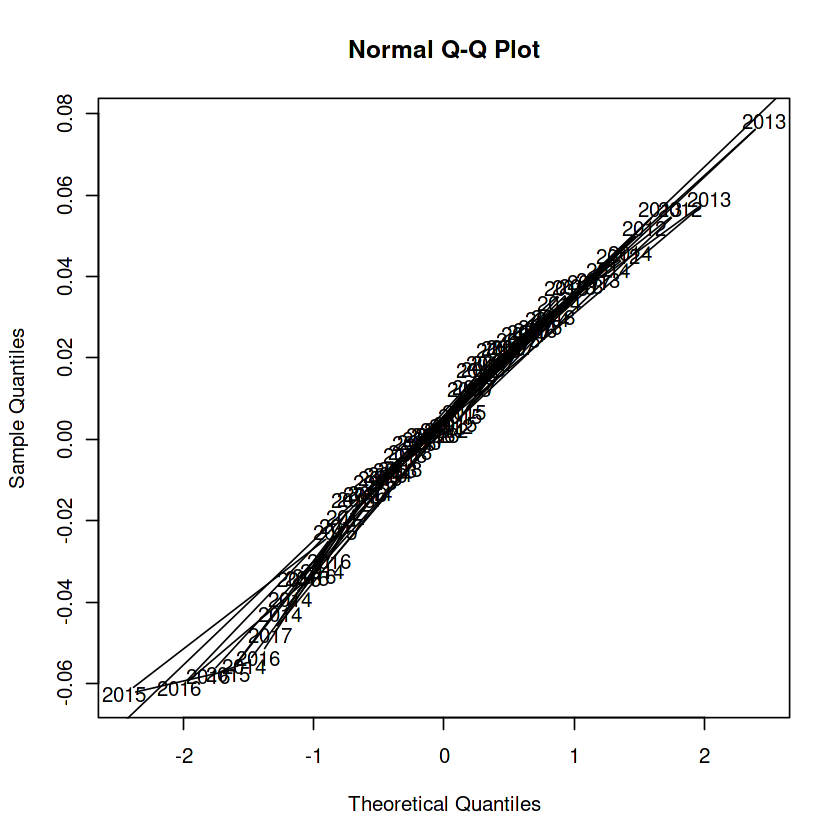


	Ljung-Box test

data:  Residuals from Seasonal naive method
Q* = 107.99, df = 17, p-value = 0.000000000000002887

Model df: 0.   Total lags used: 17

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n    miss                     mean                       sd                      min                      mdn                      max 
     72      12            0.00319256022            0.03254214252           -0.06275454353            0.00219561640            0.07810889669 


P_Value   Statistic
X-squared 0.5452753 1.212929

P_Value   Statistic
A 0.4401958 0.3596874

P_Value   Statistic
W 0.3668096 0.981436

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
-0.062755 -0.014849  0.002196  0.003193  0.026367  0.078109        12 

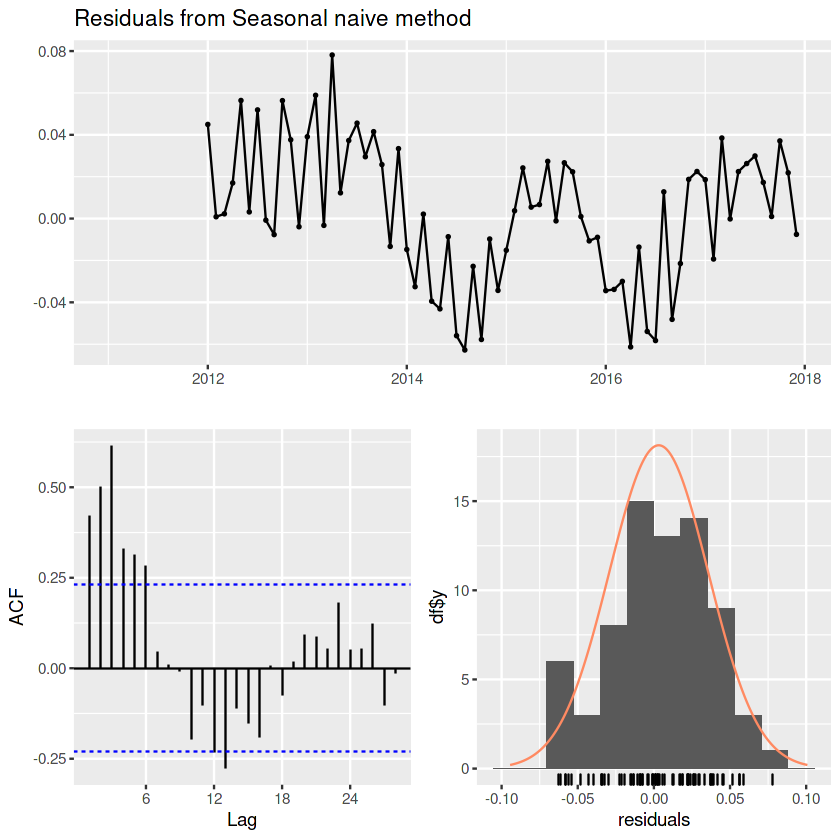

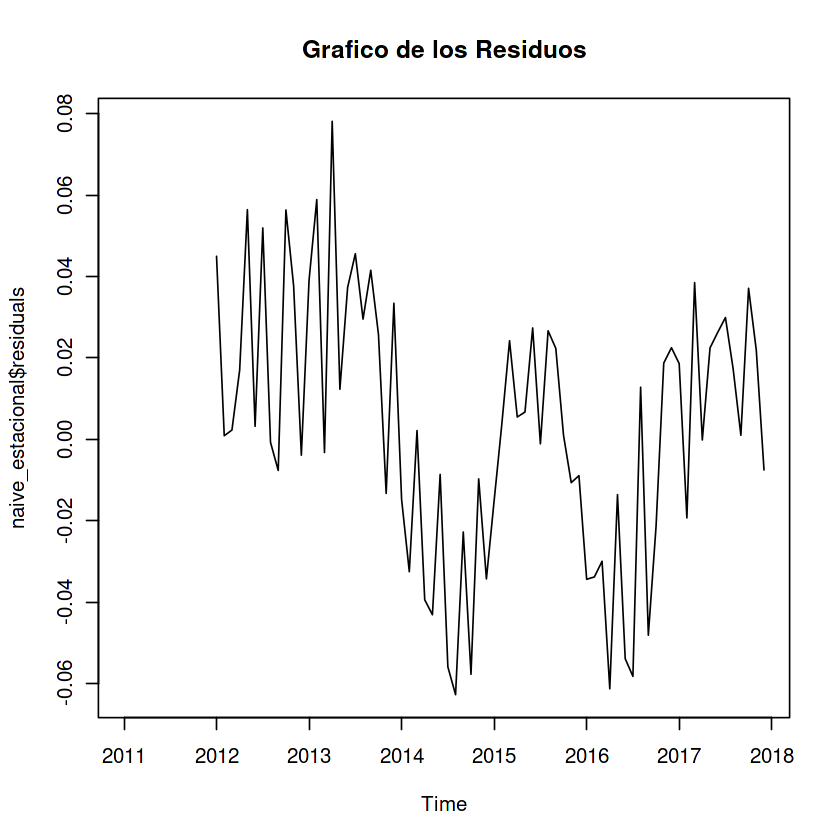

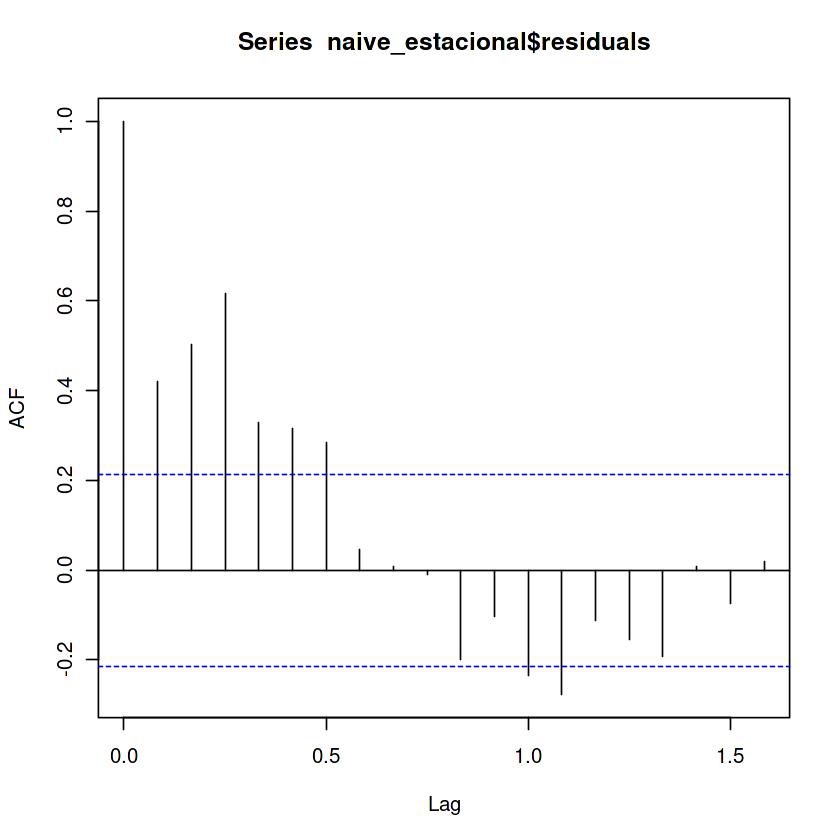

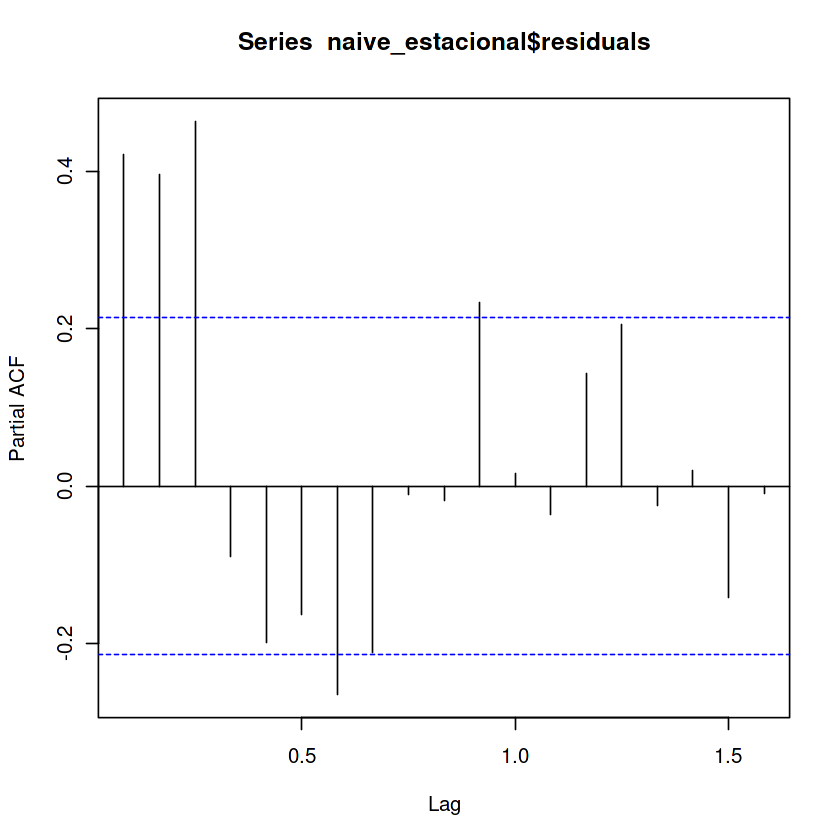

j  P_Value                  Statistic
1   1 0.0002651633679644493924  13.30172
2   2 0.0000000853453436810980  32.55312
3   3 0.0000000000002362554596  61.85293
4   4 0.0000000000000188737914  70.37720
5   5 0.0000000000000018873791  78.27154
6   6 0.0000000000000003330669  84.81786
7   7 0.0000000000000013322676  84.99481
8   8 0.0000000000000047739590  85.00209
9   9 0.0000000000000162092562  85.01000
10 10 0.0000000000000112132525  88.37347
11 11 0.0000000000000227595720  89.30777
12 12 0.0000000000000076605389  94.16749
13 13 0.0000000000000009992007 101.10956
14 14 0.0000000000000017763568 102.25094
15 15 0.0000000000000018873791 104.45363
16 16 0.0000000000000011102230 107.98188
17 17 0.0000000000000028865799 107.98851
18 18 0.0000000000000058841820 108.53179
19 19 0.0000000000000146549439 108.56926
20 20 0.0000000000000248689958 109.43806
21 21 0.0000000000000424105195 110.25642

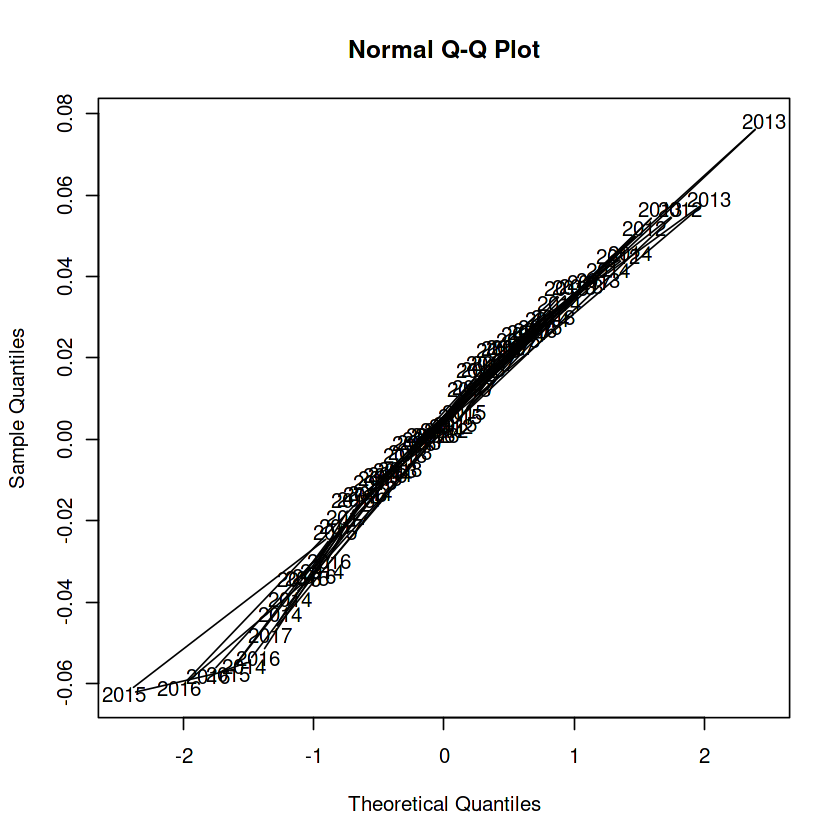

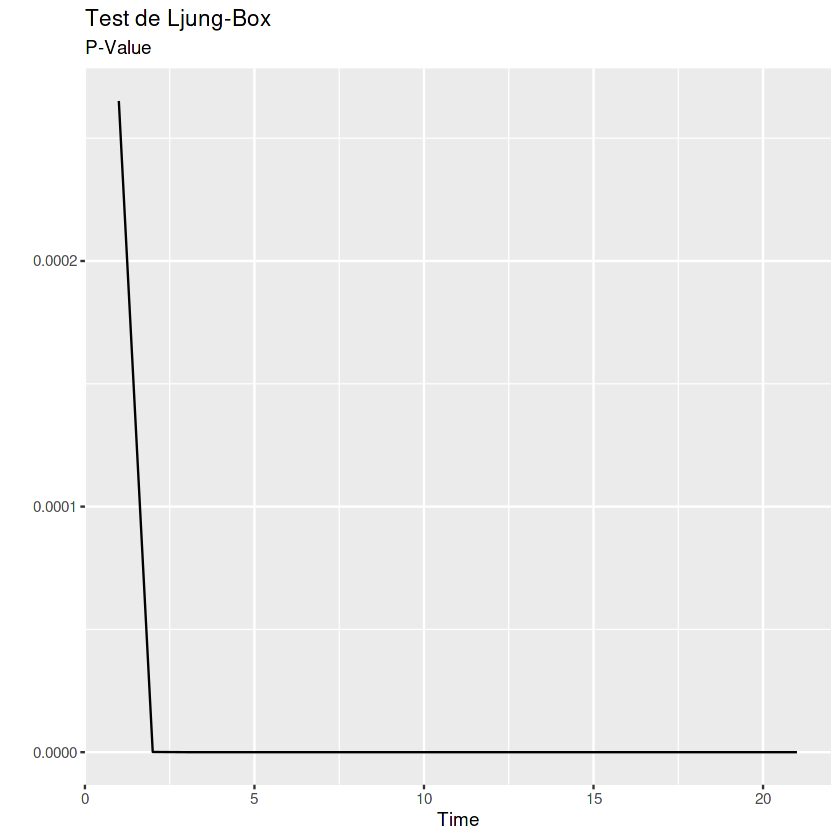

In [36]:
qqnorm(residuals(naive_estacional))
qqline(residuals(naive_estacional))

adf.test(na.omit(naive_estacional$residuals), alternative = "stationary")

checkresiduals(naive_estacional)

# Otra forma
residuos <- resid(naive_estacional)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)

# Gráficos de los residuos, ACF, PACF y qq norm
plot(naive_estacional$residuals, main = "Grafico de los Residuos")
acf(naive_estacional$residuals, na.action = na.pass)
pacf(naive_estacional$residuals, na.action = na.pass)
qqnorm(naive_estacional$residuals)

# Testeo de Incorrelación de los Residuos
Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

## Holt Winters


	Augmented Dickey-Fuller Test

data:  na.omit(expforecast$residuals)
Dickey-Fuller = -2.8357, Lag order = 12, p-value = 0.235
alternative hypothesis: stationary


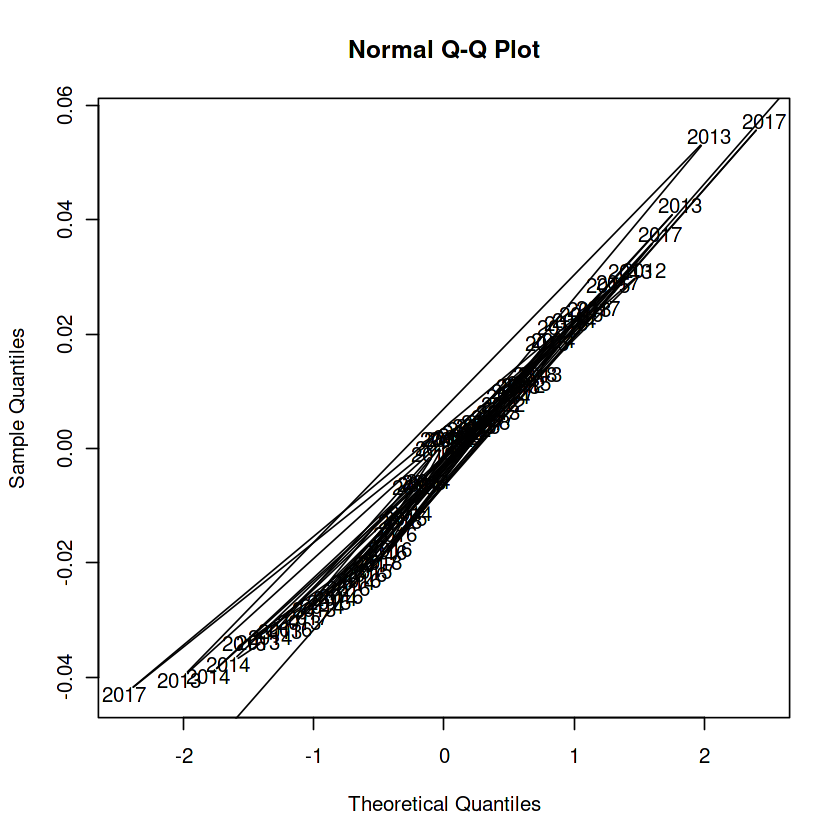

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n    miss                      mean                        sd                       min                       mdn                       max 
     72      12            -0.00239281858             0.02370871543            -0.04305133046             0.00153646523             0.05724708798 


P_Value   Statistic
X-squared 0.3790165 1.940351

P_Value   Statistic
A 0.1139991 0.6016594

P_Value    Statistic
W 0.09191039 0.9707705

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
-0.043051 -0.023197  0.001536 -0.002393  0.011841  0.057247        12 

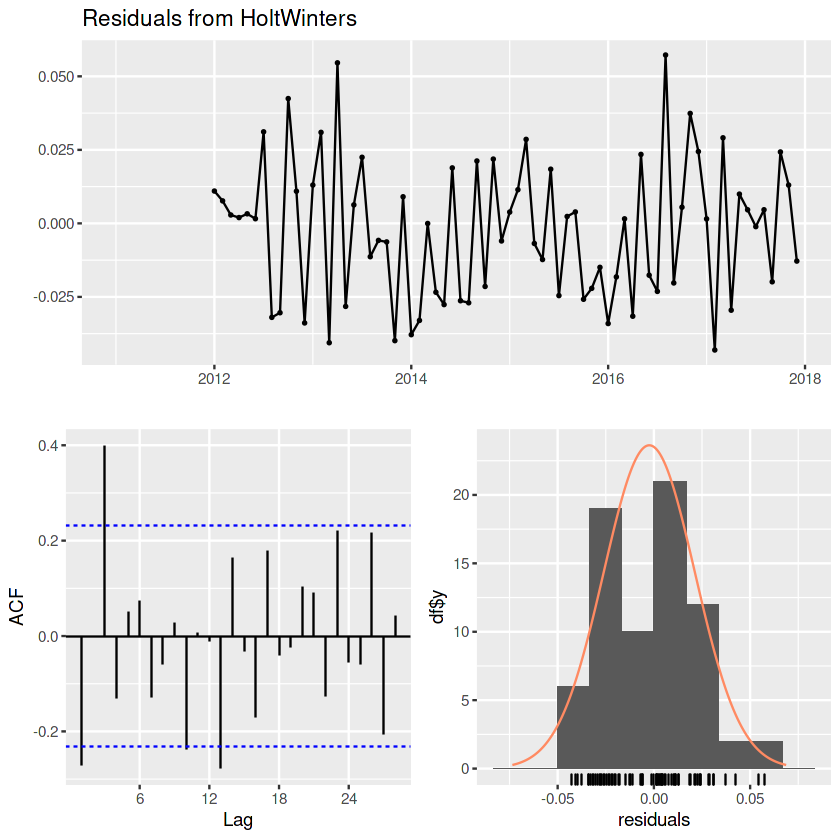

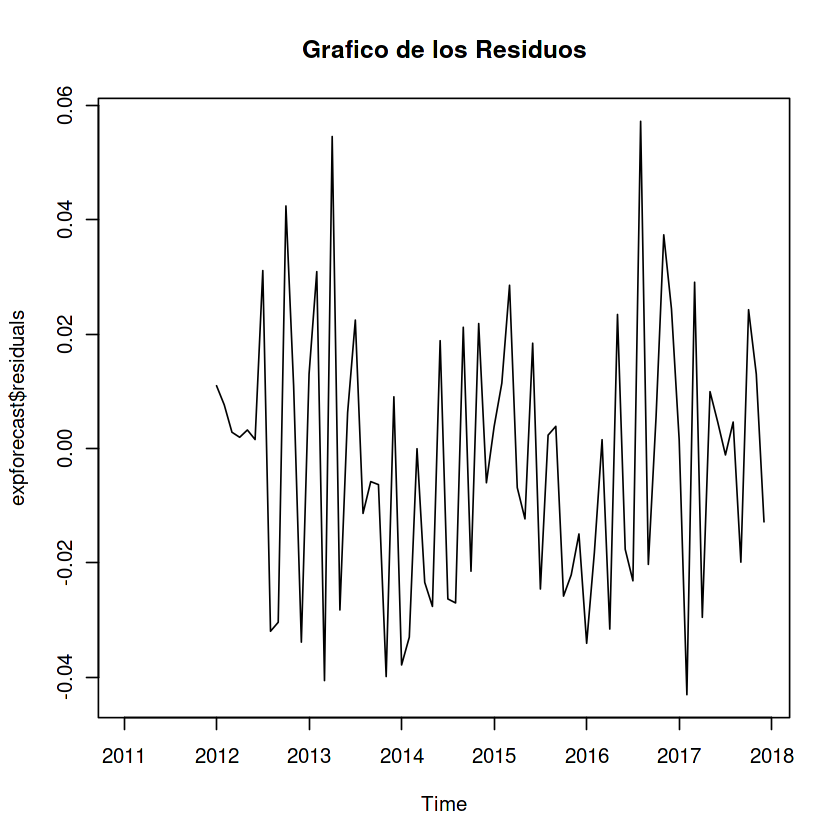

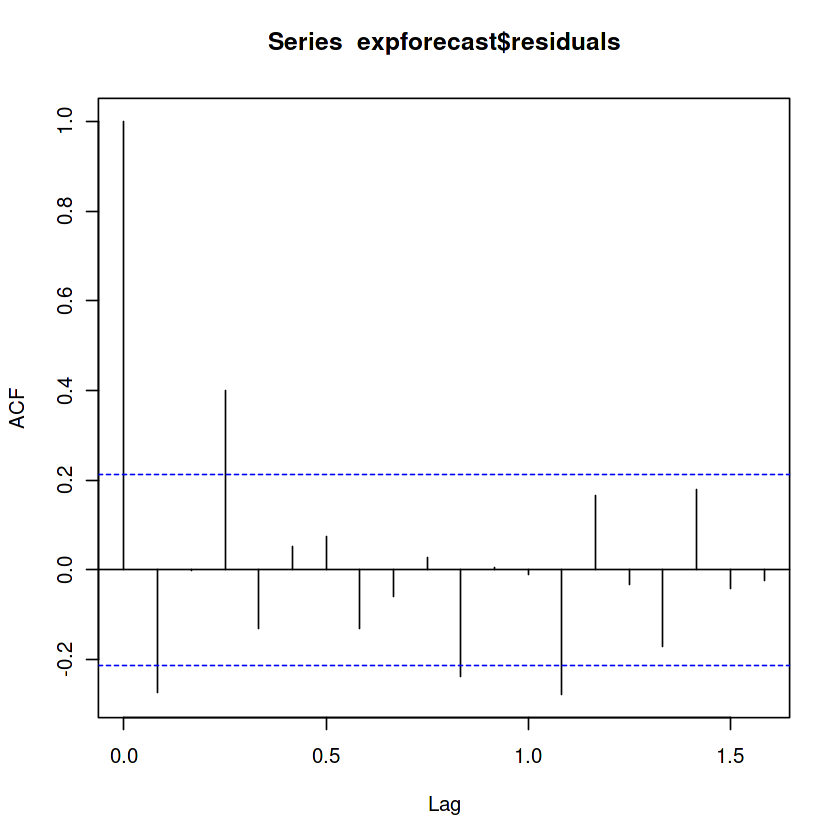

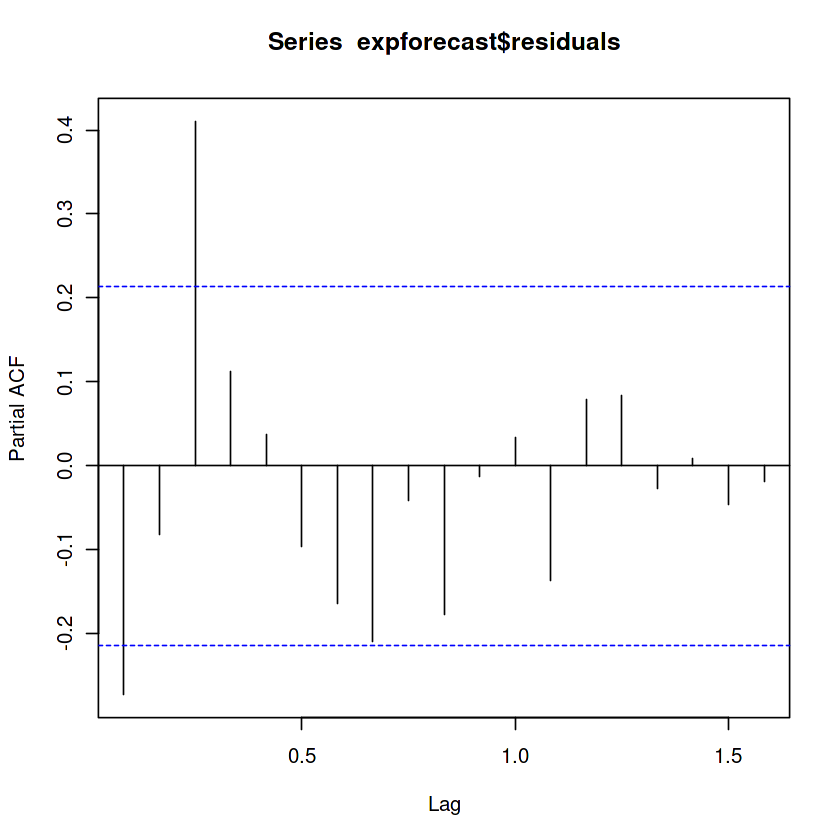

j  P_Value      Statistic
1   1 0.0182573155  5.571289
2   2 0.0616858583  5.571401
3   3 0.0004565231 17.921645
4   4 0.0007028225 19.246944
5   5 0.0015798721 19.456417
6   6 0.0028875780 19.897984
7   7 0.0033841961 21.274672
8   8 0.0057949511 21.562145
9   9 0.0101276534 21.630253
10 10 0.0031269450 26.496368
11 11 0.0054646771 26.499940
12 12 0.0090815738 26.510774
13 13 0.0014387959 33.488030
14 14 0.0010437390 35.999184
15 15 0.0017143782 36.092330
16 16 0.0011372484 38.865618
17 17 0.0006682167 42.011079
18 18 0.0010451325 42.175532
19 19 0.0016496100 42.230640
20 20 0.0018464342 43.333839
21 21 0.0021886595 44.221364

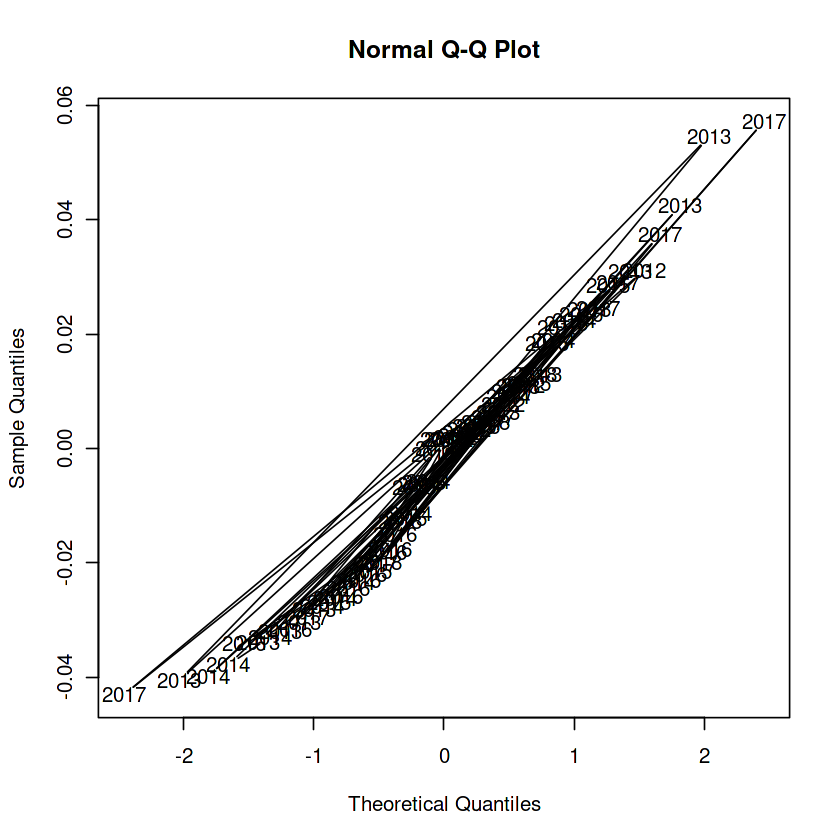

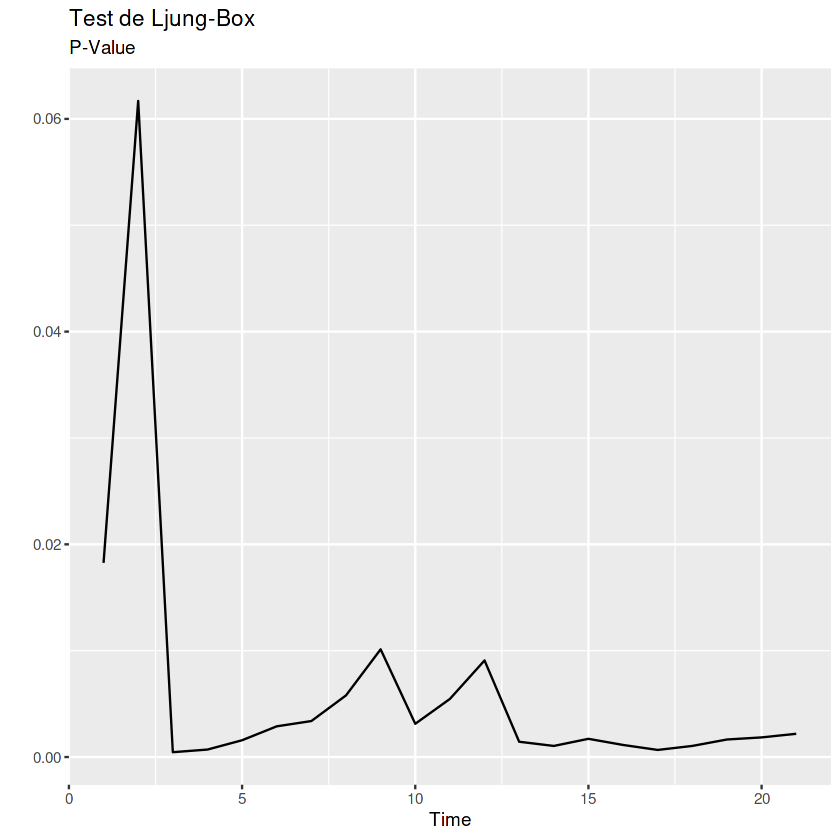

In [37]:
qqnorm(residuals(expforecast))
qqline(residuals(expforecast))

adf.test(na.omit(expforecast$residuals), alternative = "stationary", k = 12)

checkresiduals(expforecast)

# Otra forma
residuos <- resid(expforecast)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)

# Gráficos de los residuos, ACF, PACF y qq norm
plot(expforecast$residuals, main = "Grafico de los Residuos")
acf(expforecast$residuals, na.action = na.pass)
pacf(expforecast$residuals, na.action = na.pass)
qqnorm(expforecast$residuals)

# Testeo de Incorrelación de los Residuos
Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

## ARIMA

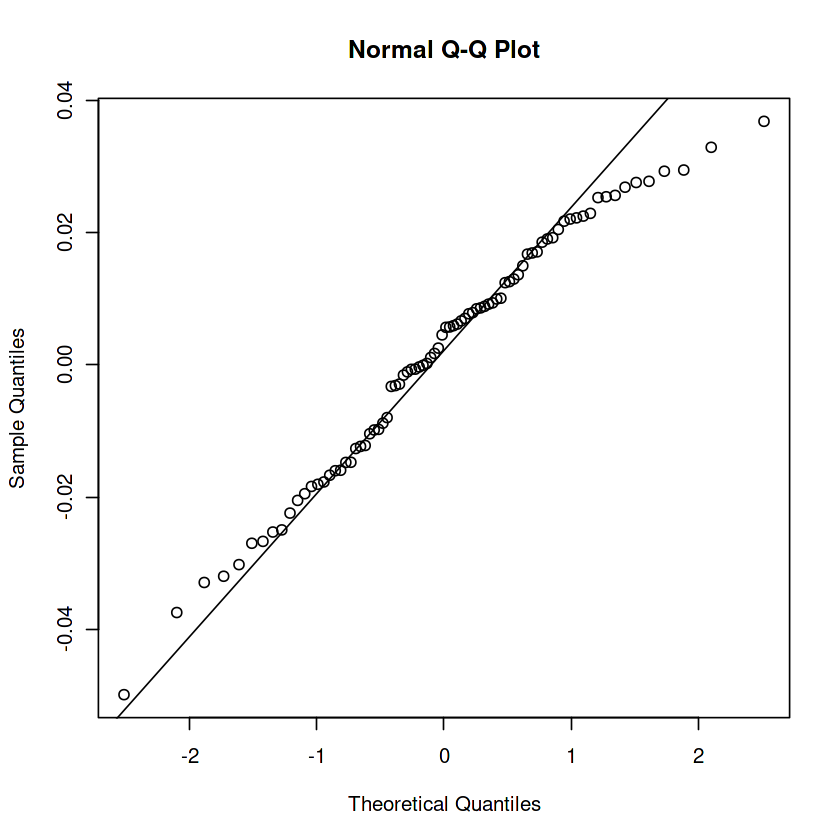

In [38]:
qqnorm(residuals(Arimaforecast))
qqline(residuals(Arimaforecast))

In [39]:
adf.test(Arimaforecast$residuals, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  Arimaforecast$residuals
Dickey-Fuller = -3.2988, Lag order = 4, p-value = 0.07741
alternative hypothesis: stationary



	Ljung-Box test

data:  Residuals from ARIMA(2,1,0)
Q* = 7.7663, df = 15, p-value = 0.9328

Model df: 2.   Total lags used: 17



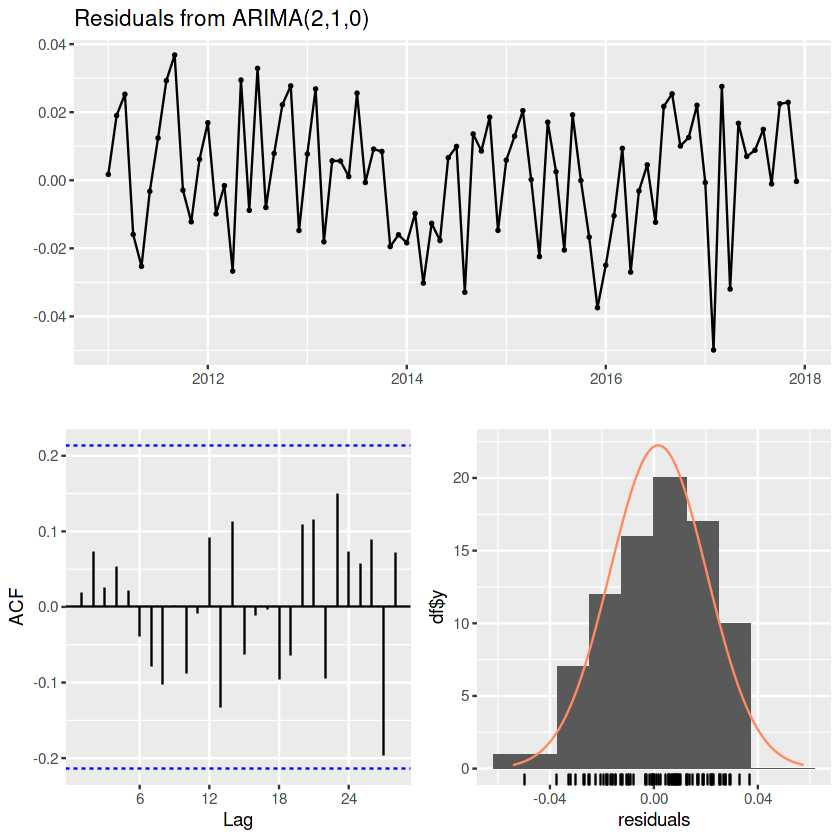

In [40]:
checkresiduals(Arimaforecast)

In [41]:
residuos <- resid(Arimaforecast)
Histogram(residuos, density = T, main = "Histograma de Residuos")

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n   miss                       mean                         sd                        min                        mdn                        max 
     84      0             0.001677436255             0.018647568932            -0.049868543904             0.005091168522             0.036803377828 


In [42]:
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

P_Value   Statistic
X-squared 0.2531336 2.747675

P_Value   Statistic
A 0.1581609 0.5434117

P_Value   Statistic
W 0.1637344 0.9781444

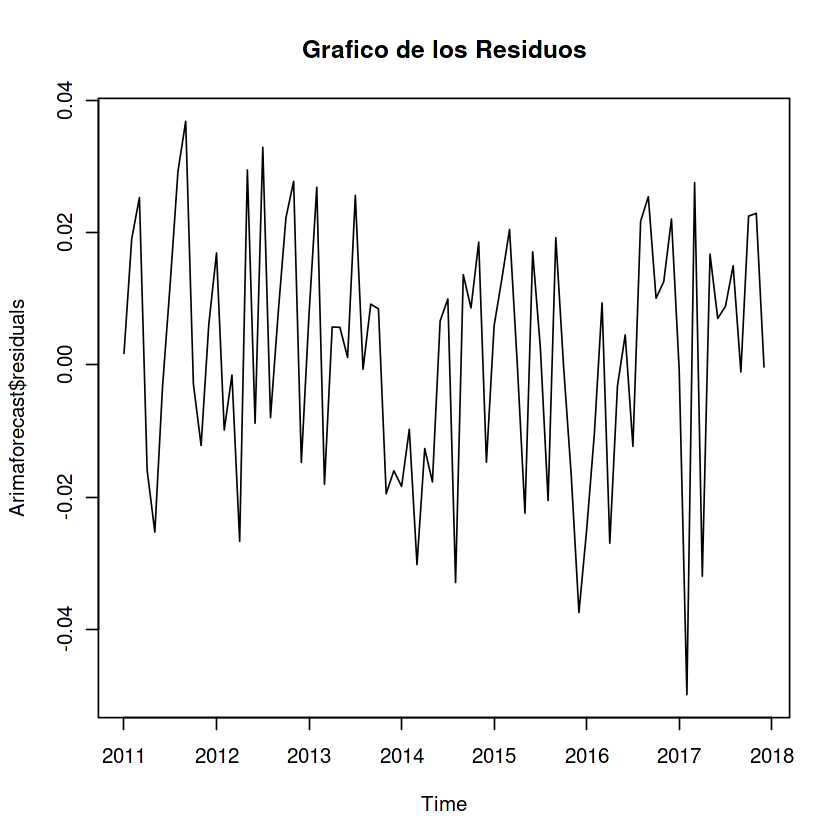

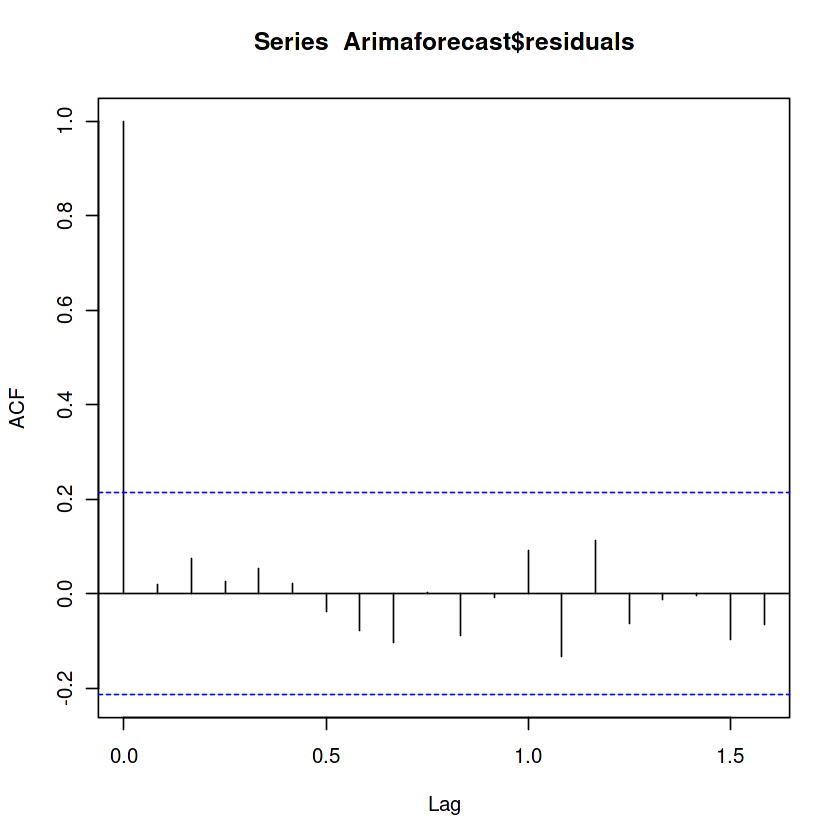

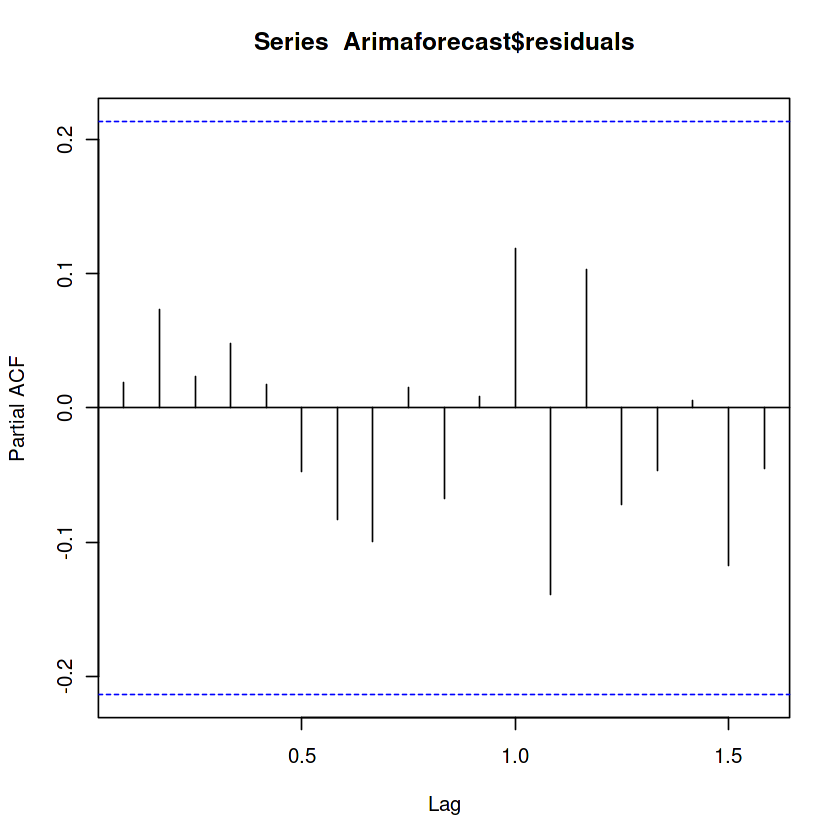

In [43]:
# Gráficos de los residuos, ACF, PACF
plot(Arimaforecast$residuals, main = "Grafico de los Residuos")
acf(Arimaforecast$residuals, na.action = na.pass)
pacf(Arimaforecast$residuals, na.action = na.pass)

j  P_Value   Statistic  
1   1 0.8571746  0.03238991
2   2 0.7748496  0.51017269
3   3 0.9030179  0.57108849
4   4 0.9339843  0.83289558
5   5 0.9717446  0.87869789
6   6 0.9849858  1.01632790
7   7 0.9787904  1.59621936
8   8 0.9571288  2.59549810
9   9 0.9781952  2.59579591
10 10 0.9716862  3.35849037
11 11 0.9849716  3.36492171
12 12 0.9795075  4.20208283
13 13 0.9454765  6.01851653
14 14 0.9213278  7.32798141
15 15 0.9333768  7.75100176
16 16 0.9555460  7.76537888
17 17 0.9712923  7.76626917
18 18 0.9647109  8.77585799
19 19 0.9692631  9.24076868
20 20 0.9566563 10.56842613
21 21 0.9365719 12.11102434

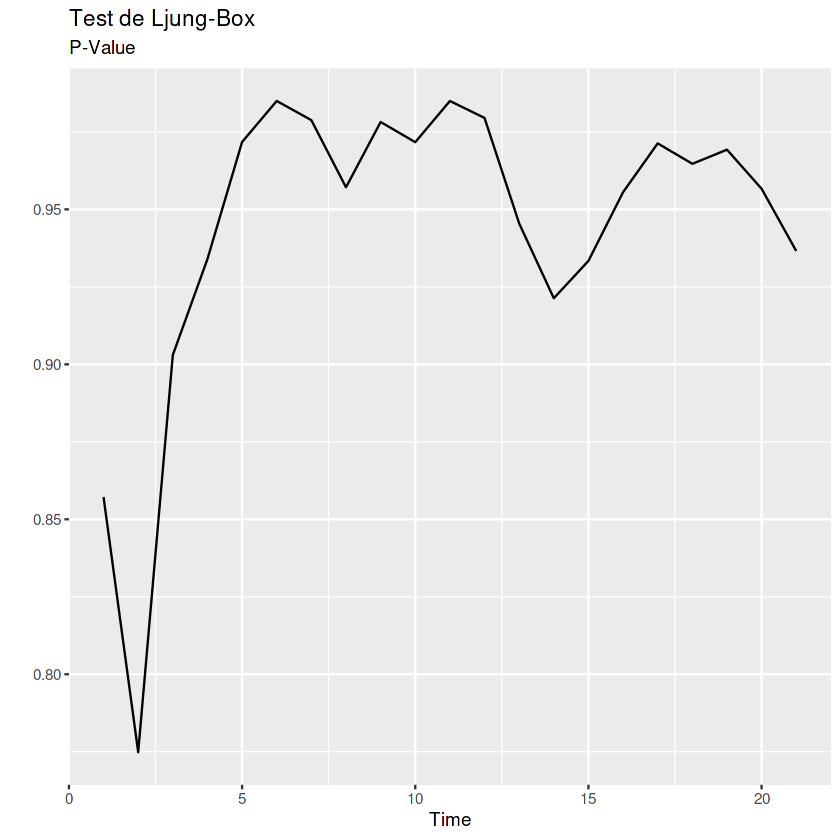

In [44]:
# Testeo de Incorrelación de los Residuos
# Si el p-value > 0.05 no estan correlacionados
Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")